# Importing and preprocessing data

In [1]:
!pip install pymatgen
!pip install megnet
import pymatgen

     |████████████████████████████████| 40.6 MB 12.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 109 kB 40.2 MB/s 
     |████████████████████████████████| 292 kB 39.8 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 98 kB 5.1 MB/s 
     |████████████████████████████████| 38.1 MB 29.2 MB/s 
     |████████████████████████████████| 546 kB 28.1 MB/s 
  Created wheel for pymatgen: filename=pymatgen-2022.0.17-cp37-cp37m-linux_x86_64.whl size=41841021 sha256=802bf0b3e226bf43d482b4bdef50372348c5c70089f225a87bfbc8622b577544
  Stored in directory: /root/.cache/pip/wheels/cf/f6/22/58a9be23c5f1b452770e02ff42047175eaf0f9c2f15219fc76
Successfully built pymatgen
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfu

In [2]:
import yaml 
import json

import pandas as pd
import numpy as np
import tensorflow as tf

from pathlib import Path
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

In [3]:
# importing baseline direcly
!git clone https://github.com/HSE-LAMBDA/IDAO-2022
!ln -s /content/IDAO-2022/baseline.py baseline.py

Cloning into 'IDAO-2022'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 2), reused 19 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [4]:
from baseline import *

# IMPORT PRIVATE HERE WITH TEST DATA WITHOUT TARGETS (ON WHICH PREDICT AND SEND SUCH PREDICTIONS ON CONTEST)
!tar -xzf /content/IDAO-2022/data/dichalcogenides_public.tar.gz
!tar -xzf /content/IDAO-2022/data/dichalcogenides_private.tar.gz

In [5]:
def prepare_dataset(dataset_path, test_mode):
    if test_mode == 'private':
        dataset_path = Path(dataset_path)
        #targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
        struct = {
            item.name.strip(".json"): read_pymatgen_dict(item)
            for item in (dataset_path / "structures").iterdir()
        }

        data = pd.DataFrame(columns=["structures"], index=struct.keys())
        data = data.assign(structures=struct.values(), targets=0)

        return data

    elif test_mode == 'public':
        dataset_path = Path(dataset_path)
        targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
        struct = {
            item.name.strip(".json"): read_pymatgen_dict(item)
            for item in (dataset_path / "structures").iterdir()
        }

        data = pd.DataFrame(columns=["structures"], index=struct.keys())
        data = data.assign(structures=struct.values(), targets=targets)

        return train_test_split(data, test_size=0.25, random_state=666) # creepy

In [6]:
public = prepare_dataset('/content/dichalcogenides_public', test_mode = 'public')
private = prepare_dataset('/content/dichalcogenides_private', test_mode = 'private')

In [13]:
train = public[0]
test = public[1]
private = private
df_train = train.copy()
df_test = test.copy()
df_private = private.copy()
# number of atoms in the lattice
def atoms_num(i):
    return len(i.as_dict()['sites'])

for k in [df_train, df_test, df_private]:
    k['atoms_num'] = k.iloc[:, 0].map(atoms_num)
unique_atoms_train = ['W', 'Mo', 'S', 'Se']
from collections import Counter
# train
count_atoms_per_lattice = dict()
for i in unique_atoms_train:
    count_atoms_per_lattice[i] = []

for i in df_train.iloc[:, 0]:
    sites = i.as_dict()['sites']
    count_atoms = Counter([sites[j]['label'] for j in range(len(sites))])
    for j in unique_atoms_train:
        if j in count_atoms.keys():
            count_atoms_per_lattice[j].append(count_atoms[j])
        else:
            count_atoms_per_lattice[j].append(0)

df_train['Mo_count'] = count_atoms_per_lattice['Mo']
df_train['S_count'] = count_atoms_per_lattice['S']
df_train['Se_count'] = count_atoms_per_lattice['Se']
df_train['W_count'] = count_atoms_per_lattice['W']

# same for test
count_atoms_per_lattice_test = dict()
for i in unique_atoms_train:
    count_atoms_per_lattice_test[i] = []

for i in df_test.iloc[:, 0]:
    sites = i.as_dict()['sites']
    count_atoms = Counter([sites[j]['label'] for j in range(len(sites))])
    for j in unique_atoms_train:
        if j in count_atoms.keys():
            count_atoms_per_lattice_test[j].append(count_atoms[j])
        else:
            count_atoms_per_lattice_test[j].append(0)

df_test['Mo_count'] = count_atoms_per_lattice_test['Mo']
df_test['S_count'] = count_atoms_per_lattice_test['S']
df_test['Se_count'] = count_atoms_per_lattice_test['Se']
df_test['W_count'] = count_atoms_per_lattice_test['W']

# same for private
count_atoms_per_lattice_private = dict()
for i in unique_atoms_train:
    count_atoms_per_lattice_private[i] = []

for i in df_private.iloc[:, 0]:
    sites = i.as_dict()['sites']
    count_atoms = Counter([sites[j]['label'] for j in range(len(sites))])
    for j in unique_atoms_train:
        if j in count_atoms.keys():
            count_atoms_per_lattice_private[j].append(count_atoms[j])
        else:
            count_atoms_per_lattice_private[j].append(0)

df_private['Mo_count'] = count_atoms_per_lattice_private['Mo']
df_private['S_count'] = count_atoms_per_lattice_private['S']
df_private['Se_count'] = count_atoms_per_lattice_private['Se']
df_private['W_count'] = count_atoms_per_lattice_private['W']
## choosing only needed columns and creating binary variables
df_train1 = df_train[['Mo_count', 'W_count', 'Se_count', 'S_count', 'targets']]
df_train1 = pd.get_dummies(df_train1, drop_first = True, columns = ['Mo_count', 'W_count', 'Se_count', 'S_count'])

df_test1 = df_test[['Mo_count', 'W_count', 'Se_count', 'S_count', 'targets']]
df_test1 = pd.get_dummies(df_test1, drop_first = True, columns = ['Mo_count', 'W_count', 'Se_count', 'S_count'])   

df_private1 = df_private[['Mo_count', 'W_count', 'Se_count', 'S_count', 'targets']]
df_private1 = pd.get_dummies(df_private1, drop_first = True, columns = ['Mo_count', 'W_count', 'Se_count', 'S_count']) 

# making equal columns
for i in df_train1.columns:
    if i not in df_test1.columns:
        df_test1[i] = 0

for i in df_train1.columns:
    if i not in df_private1.columns:
        df_private1[i] = 0


df_test1.columns = df_train1.columns
df_private1.columns = df_train1.columns
df_train1['atoms_count_group'] = 0
for i, name in enumerate(df_train1.columns[1:7]):
    df_train1['atoms_count_group'] = df_train1['atoms_count_group'] + df_train1[name] * 10**(6-i)

df_test1['atoms_count_group'] = 0
for i, name in enumerate(df_test1.columns[1:7]):
    df_test1['atoms_count_group'] = df_test1['atoms_count_group'] + df_test1[name] * 10**(6-i)

df_private1['atoms_count_group'] = 0
for i, name in enumerate(df_private1.columns[1:7]):
    df_private1['atoms_count_group'] = df_private1['atoms_count_group'] + df_private1[name] * 10**(6-i)
df_train1 = df_train1.reset_index()
df_test1 = df_test1.reset_index()
df_private1 = df_private1.reset_index()

df_pub = pd.concat([df_train1, df_test1], axis=0)   
  
# add-in: replace median with mode
# 0.02 LENGTH WINDOW
for d in [df_pub, df_train1, df_test1]:
    # MAKING UNIVERSAL ROUND, SO THERE'LL BE ROUND NOT ONLY TO CLOSEST 0.01, 0.1, 0.001 ETC, BUT FOR 0.005, 0.0025, ETC
    d['targets_round'] = np.round(d['targets'] / 0.02) * 0.02

max_mode_0_02_dic = df_pub.groupby('atoms_count_group')['targets_round'].agg(pd.Series.mode).to_dict()

for key, val in max_mode_0_02_dic.items():
    max_mode_0_02_dic[key] = np.max(max_mode_0_02_dic[key])

modes = pr_test1['atoms_count_group'].map(max_mode_0_02_dic)


modes = modes.rename('predictions')
# df_output = pd.DataFrame(output)
# df_output.update(df_priv_pred_gr10000)
# df_output.to_csv('./submission.csv', index_label='id')

# Feature Engineering

## 1) Group 10 000 (63 Mo, 126 S, 1 Se, 0 W)

In [15]:
# selecting only 10000 group
df_train1_10000 = df_train1[df_train1['atoms_count_group'] == 10000].reset_index().copy()
train_index_10000 = df_train1[df_train1['atoms_count_group'] == 10000].index

df_test1_10000 = df_test1[df_test1['atoms_count_group'] == 10000].reset_index().copy()
test_index_10000 = df_test1[df_test1['atoms_count_group'] == 10000].index

df_private1_10000 = df_private1[df_private1['atoms_count_group'] == 10000].reset_index().copy()
private_index_10000 = df_private1[df_private1['atoms_count_group'] == 10000].index
# abc of Se atom
Se_abc_10000_train = []
for i in train_index_10000:
    sample = train.iloc[i, 0].as_dict()['sites']
    for j in sample:
        if j['label'] == 'Se':
            Se_abc_10000_train.append(j['abc'])

# do the same for the test
Se_abc_10000_test = []
for i in test_index_10000:
    sample = test.iloc[i, 0].as_dict()['sites']
    for j in sample:
        if j['label'] == 'Se':
            Se_abc_10000_test.append(j['abc'])

# do the same for the private
Se_abc_10000_private = []
for i in private_index_10000:
    sample = private.iloc[i, 0].as_dict()['sites']
    for j in sample:
        if j['label'] == 'Se':
            Se_abc_10000_private.append(j['abc'])
# creating dataframe from that 
df_Se_abc_10000_train = pd.DataFrame(Se_abc_10000_train)
df_Se_abc_10000_train.columns = ['a', 'b', 'c']

df_Se_abc_10000_test = pd.DataFrame(Se_abc_10000_test)
df_Se_abc_10000_test.columns = ['a', 'b', 'c']

df_Se_abc_10000_private = pd.DataFrame(Se_abc_10000_private)
df_Se_abc_10000_private.columns = ['a', 'b', 'c']
# adding to current df
df_train1_10000['Se_a'] = round(df_Se_abc_10000_train['a'], 3)
df_train1_10000['Se_b'] = round(df_Se_abc_10000_train['b'], 3)
df_train1_10000['Se_c'] = round(df_Se_abc_10000_train['c'], 3)

df_test1_10000['Se_a'] = round(df_Se_abc_10000_test['a'], 3)
df_test1_10000['Se_b'] = round(df_Se_abc_10000_test['b'], 3)
df_test1_10000['Se_c'] = round(df_Se_abc_10000_test['c'], 3)

df_private1_10000['Se_a'] = round(df_Se_abc_10000_private['a'], 3)
df_private1_10000['Se_b'] = round(df_Se_abc_10000_private['b'], 3)
df_private1_10000['Se_c'] = round(df_Se_abc_10000_private['c'], 3)
# creating all 64 possible coordinates for Molibden and each layer of S (ANY GROUP IS THE SAME!!!)
# Molibden
Mo_a_set = []
Mo_b_set = []
Mo_c_set = []
# S, 1st and 2nd layer
S_a_set = []
S_b_set = []
S_c_set = []

for val, i in enumerate(train.iloc[0, 0].as_dict()['sites']):
    if val < 63:
        Mo_a_set.append(round(i['abc'][0], 3))
        Mo_b_set.append(round(i['abc'][1], 3))
        Mo_c_set.append(round(i['abc'][2], 3))
    # skipping Se atom
    elif val > 64:
        S_a_set.append(round(i['abc'][0], 3))
        S_b_set.append(round(i['abc'][1], 3))
        S_c_set.append(round(i['abc'][2], 3))

print('Molibden')
Mo_a_set = sorted(list(set(Mo_a_set)))
Mo_b_set = sorted(list(set(Mo_b_set)))
Mo_c_set = sorted(list(set(Mo_c_set)))[0]
# print(Mo_a_set)
# print(Mo_b_set)
# print(Mo_c_set)

# print('S')
S_a_set = sorted(list(set(S_a_set)))
S_b_set = sorted(list(set(S_b_set)))
S_c_set = sorted(list(set(S_c_set)))
# print(S_a_set)
# print(S_b_set)
# print(S_c_set)
# LOL, it's just vice versa a and b for Mo and S!!!
# creating list of 64 places for Mo and 128 places for S in the correct order
Mo_64_coordinates = []
for i in Mo_a_set:
    for j in Mo_b_set:
        Mo_64_coordinates.append([i, j, Mo_c_set])

S_128_coordinates = []
for i in S_c_set:
    for j in S_a_set:
        for k in S_b_set:
            S_128_coordinates.append([j, k, i])
# DETECTING MISSED ATOMS(USING ALGORITHM ABOVE) FOR ALL LATTICES IN THE GROUP 10000!!!!
num_molibden_atoms = 63
num_rubbish_atoms = 1
num_S_atoms = 126

Mo_missed = 64 - num_molibden_atoms
S_missed = 128 - num_S_atoms

missed_atoms_coordinates_group10000_train = []
missed_atoms_coordinates_group10000_test = []
missed_atoms_coordinates_group10000_private = []

indices = [train_index_10000, test_index_10000, private_index_10000]
coordinates_list = [missed_atoms_coordinates_group10000_train,
                    missed_atoms_coordinates_group10000_test,
                    missed_atoms_coordinates_group10000_private]
datasets = [train, test, private]

for ind in range(3):
    for j in indices[ind]:
        missed_atoms_coordinates_lattice = []

        Mo_atom_missed_counter = 0
        S_atom_missed_counter = 0

        lattice_sample = datasets[ind].iloc[j, 0].as_dict()['sites']

        for val, i in enumerate(lattice_sample):
            # first Mo atom
            if val == 0 and round(i['abc'][1], 3) != 0.083:
                missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                Mo_atom_missed_counter += 1
            # other Mo atoms
            elif val > 0 and val < num_molibden_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                    Mo_atom_missed_counter += 1

            # first S atom
            elif val == num_molibden_atoms + num_rubbish_atoms:
                if round(i['abc'][1], 3) != 0.042:
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1

            # other S atoms
            elif val > num_molibden_atoms + num_rubbish_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1
                    # Case if missed atoms are together!!! This is special case to be algorithmed below!!!!
                # UPD: MISTAKE, --------------------------------------------------------------------------------------------------------> DON'T ADD 1 BELOW!!!! AS S_atom_missed_counter was updated!!!!
                    if (diff_b_with_prev != 0.25) & (diff_b_with_prev != -0.75):
                        missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                        S_atom_missed_counter += 1
                        break

        # if missed atoms are on last positions, so the algorithm above does not catch them
        # Molibden
        if Mo_atom_missed_counter != Mo_missed:
            missed_atoms_coordinates_lattice = Mo_64_coordinates[63] + missed_atoms_coordinates_lattice
            Mo_atom_missed_counter += 1
            
        # S
        if S_atom_missed_counter - S_missed == -2:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[126]
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 2
        elif S_atom_missed_counter - S_missed == -1:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 1

        coordinates_list[ind].append(missed_atoms_coordinates_lattice)
# df of missed atoms!!!
df_missed_coord_10000_train = pd.DataFrame(missed_atoms_coordinates_group10000_train)
df_missed_coord_10000_test = pd.DataFrame(missed_atoms_coordinates_group10000_test)
df_missed_coord_10000_private = pd.DataFrame(missed_atoms_coordinates_group10000_private)
main_datasets = [df_train1_10000, df_test1_10000, df_private1_10000]
prelim_datasets = [df_missed_coord_10000_train, df_missed_coord_10000_test, df_missed_coord_10000_private]

for i in range(3):
    main_datasets[i]['missed_Mo_a'] = prelim_datasets[i][0]
    main_datasets[i]['missed_Mo_b'] = prelim_datasets[i][1]
    main_datasets[i]['missed_Mo_c'] = prelim_datasets[i][2]
    main_datasets[i]['missed_S1_a'] = prelim_datasets[i][3]
    main_datasets[i]['missed_S1_b'] = prelim_datasets[i][4]
    main_datasets[i]['missed_S1_c'] = prelim_datasets[i][5]
    main_datasets[i]['missed_S2_a'] = prelim_datasets[i][6]
    main_datasets[i]['missed_S2_b'] = prelim_datasets[i][7]
    main_datasets[i]['missed_S2_c'] = prelim_datasets[i][8]
cols_to_leave = ['level_0', 'index', 'targets', 'Se_a', 'Se_b', 'Se_c',
       'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c', 'missed_S1_a',
       'missed_S1_b', 'missed_S1_c', 'missed_S2_a', 'missed_S2_b',
       'missed_S2_c']

train10000 = df_train1_10000[cols_to_leave]
test10000 = df_test1_10000[cols_to_leave]
private10000 = df_private1_10000[cols_to_leave]
def substantial_impurity_detector(i):
    if round(i['Se_a'], 3) == i['missed_S1_a'] and round(i['Se_b'], 3) == i['missed_S1_b'] and round(i['Se_c'], 3) == i['missed_S1_c']:
        return 1
    elif round(i['Se_a'], 3) == i['missed_S2_a'] and round(i['Se_b'], 3) == i['missed_S2_b'] and round(i['Se_c'], 3) == i['missed_S2_c']:
        return 2
    else:
        return 0
train10000['impurity_atom'] = train10000.apply(substantial_impurity_detector, axis = 1)
test10000['impurity_atom'] = test10000.apply(substantial_impurity_detector, axis = 1)
private10000['impurity_atom'] = private10000.apply(substantial_impurity_detector, axis = 1)
train10000_new = train10000.copy()
test10000_new = test10000.copy()
private10000_new = private10000.copy()

new_dfs = []

for df in [train10000_new, test10000_new, private10000_new]:
    df['vacancyS_a'] = df.apply(lambda x: x['missed_S1_a'] if x['impurity_atom'] == 2 else x['missed_S2_a'], axis = 1)
    df['vacancyS_b'] = df.apply(lambda x: x['missed_S1_b'] if x['impurity_atom'] == 2 else x['missed_S2_b'], axis = 1)
    df['vacancyS_c'] = df.apply(lambda x: x['missed_S1_c'] if x['impurity_atom'] == 2 else x['missed_S2_c'], axis = 1)

    df['Se_a'] = np.round(df['Se_a'], 3)
    df['Se_b'] = np.round(df['Se_b'], 3)
    df['Se_c'] = np.round(df['Se_c'], 3)

    cols_to_leave = ['level_0', 'index', 'targets', 'Se_a', 'Se_b', 'Se_c',
          'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c', 'vacancyS_a', 'vacancyS_b', 'vacancyS_c']

    df = df[cols_to_leave].copy()

    new_col_names = ['level_0', 'index', 'targets', 'Se_impurityS_a', 'Se_impurityS_b', 'Se_impurityS_c',
          'vacancyMo_a', 'vacancyMo_b', 'vacancyMo_c', 'vacancyS_a', 'vacancyS_b', 'vacancyS_c']
    df.columns = new_col_names

    new_dfs.append(df)

train10000_new = new_dfs[0]
test10000_new = new_dfs[1]
private10000_new = new_dfs[2]
# FROM OBSERVATION OF THE COORDINATES!!!
mean_a = 0.5
mean_b = 0.5
mean_c = 0.25

for df in [train10000_new, test10000_new, private10000_new]:
    df['Se_impurityS_dist_to_center'] = np.sqrt((df['Se_impurityS_a']-mean_a)**2 + (df['Se_impurityS_b']-mean_b)**2 + (df['Se_impurityS_c']-mean_c)**2)
    df['vacancyMo_dist_to_center'] = np.sqrt((df['vacancyMo_a']-mean_a)**2 + (df['vacancyMo_b']-mean_b)**2 + (df['vacancyMo_c']-mean_c)**2)
    df['vacancyS_dist_to_center'] = np.sqrt((df['vacancyS_a']-mean_a)**2 + (df['vacancyS_b']-mean_b)**2 + (df['vacancyS_c']-mean_c)**2)
train_df10000 = train10000_new.copy()
valid_df10000 = test10000_new.copy()
private_df10000 = private10000_new.copy()
# another 3 features, All pairwise distances between the vacancy and impurity coordinates!!!
dfs = [train_df10000, valid_df10000, private_df10000]
for df in dfs:
    df['dist_Se_impurityS_vacancyMo'] = np.sqrt((df['Se_impurityS_a'] - df['vacancyMo_a'])**2\
                                                         + (df['Se_impurityS_b'] - df['vacancyMo_b'])**2\
                                                         + (df['Se_impurityS_c'] - df['vacancyMo_c'])**2)
    df['dist_Se_impurityS_vacancyS'] = np.sqrt((df['Se_impurityS_a'] - df['vacancyS_a'])**2\
                                                            + (df['Se_impurityS_b'] - df['vacancyS_b'])**2\
                                                            + (df['Se_impurityS_c'] - df['vacancyS_c'])**2)
    df['dist_vacancyMo_vacancyS'] = np.sqrt((df['vacancyMo_a'] - df['vacancyS_a'])**2\
                                                        + (df['vacancyMo_b'] - df['vacancyS_b'])**2\
                                                        + (df['vacancyMo_c'] - df['vacancyS_c'])**2)

# euclidean sum of distances
for df in dfs:
    df['eucl_sum_distance'] = np.sqrt(df['dist_Se_impurityS_vacancyMo']**2 +\
                                      df['dist_Se_impurityS_vacancyS']**2 +\
                                      df['dist_vacancyMo_vacancyS']**2)
    
# another 3 features: distances from the origin
for df in dfs:
    df['dist_Se_impurityS_origin'] = np.sqrt((df['Se_impurityS_a'])**2\
                                                          + (df['Se_impurityS_b'])**2\
                                                          + (df['Se_impurityS_c'])**2)
    df['dist_vacancyS_origin'] = np.sqrt((df['vacancyS_a'])**2\
                                                      + (df['vacancyS_b'])**2\
                                                      + (df['vacancyS_c'])**2)
    df['dist_vacancyMo_origin'] = np.sqrt((df['vacancyMo_a'])**2\
                                                      + (df['vacancyMo_b'])**2\
                                                      + (df['vacancyMo_c'])**2)
def cos_creator1(i):
    dist2D = np.sqrt(i['dist_vacancyMo_vacancyS']**2 - (i['vacancyMo_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS_c']:
        return (i['vacancyS_a'] - i['vacancyMo_a']) / dist2D
    # pivot is vacancyS
    else:
        return (i['vacancyMo_a'] - i['vacancyS_a']) / dist2D

def sin_creator1(i):
    dist2D = np.sqrt(i['dist_vacancyMo_vacancyS']**2 - (i['vacancyMo_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS_c']:
        return (i['vacancyS_b'] - i['vacancyMo_b']) / dist2D
    else:
        return (i['vacancyMo_b'] - i['vacancyS_b']) / dist2D


def cos_creator2(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyS']**2 - (i['Se_impurityS_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se_impurityS:
    elif i['Se_impurityS_c'] < i['vacancyS_c']:
        return (i['vacancyS_a'] - i['Se_impurityS_a']) / dist2D
    # pivot is vacancyS
    else:
        return (i['Se_impurityS_a'] - i['vacancyS_a']) / dist2D

def sin_creator2(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyS']**2 - (i['Se_impurityS_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se_impurityS:
    elif i['Se_impurityS_c'] < i['vacancyS_c']:
        return (i['vacancyS_b'] - i['Se_impurityS_b']) / dist2D
    else:
        return (i['Se_impurityS_b'] - i['vacancyS_b']) / dist2D


def cos_creator3(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyMo']**2 - (i['vacancyMo_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_a'] - i['vacancyMo_a']) / dist2D
    # pivot is Se_impurityS
    else:
        return (i['vacancyMo_a'] - i['Se_impurityS_a']) / dist2D

def sin_creator3(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyMo']**2 - (i['vacancyMo_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_b'] - i['vacancyMo_b']) / dist2D
    else:
        return (i['vacancyMo_b'] - i['Se_impurityS_b']) / dist2D
# applying tricky angle!!!
dfs = [train_df10000, valid_df10000, private_df10000]
for df in dfs:
    df['sin_tricky1'] = df.apply(sin_creator1, axis = 1)
    df['cos_tricky1'] = df.apply(cos_creator1, axis = 1)
    df['tan_tricky1'] = df['sin_tricky1'] / (df['cos_tricky1'] + 0.00001)
    df['ctg_tricky1'] = df['cos_tricky1'] / (df['sin_tricky1'] + 0.00001)

    df['sin_tricky2'] = df.apply(sin_creator2, axis = 1)
    df['cos_tricky2'] = df.apply(cos_creator2, axis = 1)
    df['tan_tricky2'] = df['sin_tricky2'] / (df['cos_tricky2'] + 0.00001)
    df['ctg_tricky2'] = df['cos_tricky2'] / (df['sin_tricky2'] + 0.00001)

    df['sin_tricky3'] = df.apply(sin_creator3, axis = 1)
    df['cos_tricky3'] = df.apply(cos_creator3, axis = 1)
    df['tan_tricky3'] = df['sin_tricky3'] / (df['cos_tricky3'] + 0.00001)
    df['ctg_tricky3'] = df['cos_tricky3'] / (df['sin_tricky3'] + 0.00001)
# another 2 features, binary variables, depending on the C coordinates of the atoms on S places!!!
dfs = [train_df10000, valid_df10000, private_df10000]
for df in dfs:
    df['C_atomsS_same'] = (df['vacancyS_c'] == df['Se_impurityS_c']).astype('int')
    df['vacancyS_c_0_355'] = (df['vacancyS_c'] == 0.355).astype('int')
train_df10000.head()
valid_df10000.head()
private_df10000.head()
train_df10000.shape, valid_df10000.shape, private_df10000.shape

Molibden


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

((501, 36), (201, 36), (713, 36))

In [16]:
# selecting only 10000 group
df_train1_10000 = df_train1[df_train1['atoms_count_group'] == 10000].reset_index().copy()
train_index_10000 = df_train1[df_train1['atoms_count_group'] == 10000].index

df_test1_10000 = df_test1[df_test1['atoms_count_group'] == 10000].reset_index().copy()
test_index_10000 = df_test1[df_test1['atoms_count_group'] == 10000].index

df_private1_10000 = df_private1[df_private1['atoms_count_group'] == 10000].reset_index().copy()
private_index_10000 = df_private1[df_private1['atoms_count_group'] == 10000].index
# abc of Se atom
Se_abc_10000_train = []
for i in train_index_10000:
    sample = train.iloc[i, 0].as_dict()['sites']
    for j in sample:
        if j['label'] == 'Se':
            Se_abc_10000_train.append(j['abc'])

# do the same for the test
Se_abc_10000_test = []
for i in test_index_10000:
    sample = test.iloc[i, 0].as_dict()['sites']
    for j in sample:
        if j['label'] == 'Se':
            Se_abc_10000_test.append(j['abc'])

# do the same for the private
Se_abc_10000_private = []
for i in private_index_10000:
    sample = private.iloc[i, 0].as_dict()['sites']
    for j in sample:
        if j['label'] == 'Se':
            Se_abc_10000_private.append(j['abc'])
# creating dataframe from that 
df_Se_abc_10000_train = pd.DataFrame(Se_abc_10000_train)
df_Se_abc_10000_train.columns = ['a', 'b', 'c']

df_Se_abc_10000_test = pd.DataFrame(Se_abc_10000_test)
df_Se_abc_10000_test.columns = ['a', 'b', 'c']

df_Se_abc_10000_private = pd.DataFrame(Se_abc_10000_private)
df_Se_abc_10000_private.columns = ['a', 'b', 'c']
# adding to current df
df_train1_10000['Se_a'] = round(df_Se_abc_10000_train['a'], 3)
df_train1_10000['Se_b'] = round(df_Se_abc_10000_train['b'], 3)
df_train1_10000['Se_c'] = round(df_Se_abc_10000_train['c'], 3)

df_test1_10000['Se_a'] = round(df_Se_abc_10000_test['a'], 3)
df_test1_10000['Se_b'] = round(df_Se_abc_10000_test['b'], 3)
df_test1_10000['Se_c'] = round(df_Se_abc_10000_test['c'], 3)

df_private1_10000['Se_a'] = round(df_Se_abc_10000_private['a'], 3)
df_private1_10000['Se_b'] = round(df_Se_abc_10000_private['b'], 3)
df_private1_10000['Se_c'] = round(df_Se_abc_10000_private['c'], 3)
# creating all 64 possible coordinates for Molibden and each layer of S (ANY GROUP IS THE SAME!!!)
# Molibden
Mo_a_set = []
Mo_b_set = []
Mo_c_set = []
# S, 1st and 2nd layer
S_a_set = []
S_b_set = []
S_c_set = []

for val, i in enumerate(train.iloc[0, 0].as_dict()['sites']):
    if val < 63:
        Mo_a_set.append(round(i['abc'][0], 3))
        Mo_b_set.append(round(i['abc'][1], 3))
        Mo_c_set.append(round(i['abc'][2], 3))
    # skipping Se atom
    elif val > 64:
        S_a_set.append(round(i['abc'][0], 3))
        S_b_set.append(round(i['abc'][1], 3))
        S_c_set.append(round(i['abc'][2], 3))

print('Molibden')
Mo_a_set = sorted(list(set(Mo_a_set)))
Mo_b_set = sorted(list(set(Mo_b_set)))
Mo_c_set = sorted(list(set(Mo_c_set)))[0]
print(Mo_a_set)
print(Mo_b_set)
print(Mo_c_set)

print('S')
S_a_set = sorted(list(set(S_a_set)))
S_b_set = sorted(list(set(S_b_set)))
S_c_set = sorted(list(set(S_c_set)))
print(S_a_set)
print(S_b_set)
print(S_c_set)
# LOL, it's just vice versa a and b for Mo and S!!!
# creating list of 64 places for Mo and 128 places for S in the correct order
Mo_64_coordinates = []
for i in Mo_a_set:
    for j in Mo_b_set:
        Mo_64_coordinates.append([i, j, Mo_c_set])

S_128_coordinates = []
for i in S_c_set:
    for j in S_a_set:
        for k in S_b_set:
            S_128_coordinates.append([j, k, i])
# DETECTING MISSED ATOMS(USING ALGORITHM ABOVE) FOR ALL LATTICES IN THE GROUP 10000!!!!
num_molibden_atoms = 63
num_rubbish_atoms = 1
num_S_atoms = 126

Mo_missed = 64 - num_molibden_atoms
S_missed = 128 - num_S_atoms

missed_atoms_coordinates_group10000_train = []
missed_atoms_coordinates_group10000_test = []
missed_atoms_coordinates_group10000_private = []

indices = [train_index_10000, test_index_10000, private_index_10000]
coordinates_list = [missed_atoms_coordinates_group10000_train,
                    missed_atoms_coordinates_group10000_test,
                    missed_atoms_coordinates_group10000_private]
datasets = [train, test, private]

for ind in range(3):
    for j in indices[ind]:
        missed_atoms_coordinates_lattice = []

        Mo_atom_missed_counter = 0
        S_atom_missed_counter = 0

        lattice_sample = datasets[ind].iloc[j, 0].as_dict()['sites']

        for val, i in enumerate(lattice_sample):
            # first Mo atom
            if val == 0 and round(i['abc'][1], 3) != 0.083:
                missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                Mo_atom_missed_counter += 1
            # other Mo atoms
            elif val > 0 and val < num_molibden_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                    Mo_atom_missed_counter += 1

            # first S atom
            elif val == num_molibden_atoms + num_rubbish_atoms:
                if round(i['abc'][1], 3) != 0.042:
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1

            # other S atoms
            elif val > num_molibden_atoms + num_rubbish_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1
                    # Case if missed atoms are together!!! This is special case to be algorithmed below!!!!
                # UPD: MISTAKE, --------------------------------------------------------------------------------------------------------> DON'T ADD 1 BELOW!!!! AS S_atom_missed_counter was updated!!!!
                    if (diff_b_with_prev != 0.25) & (diff_b_with_prev != -0.75):
                        missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                        S_atom_missed_counter += 1
                        break

        # if missed atoms are on last positions, so the algorithm above does not catch them
        # Molibden
        if Mo_atom_missed_counter != Mo_missed:
            missed_atoms_coordinates_lattice = Mo_64_coordinates[63] + missed_atoms_coordinates_lattice
            Mo_atom_missed_counter += 1
            
        # S
        if S_atom_missed_counter - S_missed == -2:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[126]
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 2
        elif S_atom_missed_counter - S_missed == -1:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 1

        coordinates_list[ind].append(missed_atoms_coordinates_lattice)
# df of missed atoms!!!
df_missed_coord_10000_train = pd.DataFrame(missed_atoms_coordinates_group10000_train)
df_missed_coord_10000_test = pd.DataFrame(missed_atoms_coordinates_group10000_test)
df_missed_coord_10000_private = pd.DataFrame(missed_atoms_coordinates_group10000_private)
main_datasets = [df_train1_10000, df_test1_10000, df_private1_10000]
prelim_datasets = [df_missed_coord_10000_train, df_missed_coord_10000_test, df_missed_coord_10000_private]

for i in range(3):
    main_datasets[i]['missed_Mo_a'] = prelim_datasets[i][0]
    main_datasets[i]['missed_Mo_b'] = prelim_datasets[i][1]
    main_datasets[i]['missed_Mo_c'] = prelim_datasets[i][2]
    main_datasets[i]['missed_S1_a'] = prelim_datasets[i][3]
    main_datasets[i]['missed_S1_b'] = prelim_datasets[i][4]
    main_datasets[i]['missed_S1_c'] = prelim_datasets[i][5]
    main_datasets[i]['missed_S2_a'] = prelim_datasets[i][6]
    main_datasets[i]['missed_S2_b'] = prelim_datasets[i][7]
    main_datasets[i]['missed_S2_c'] = prelim_datasets[i][8]
cols_to_leave = ['level_0', 'index', 'targets', 'Se_a', 'Se_b', 'Se_c',
       'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c', 'missed_S1_a',
       'missed_S1_b', 'missed_S1_c', 'missed_S2_a', 'missed_S2_b',
       'missed_S2_c']

train10000 = df_train1_10000[cols_to_leave]
test10000 = df_test1_10000[cols_to_leave]
private10000 = df_private1_10000[cols_to_leave]
def substantial_impurity_detector(i):
    if round(i['Se_a'], 3) == i['missed_S1_a'] and round(i['Se_b'], 3) == i['missed_S1_b'] and round(i['Se_c'], 3) == i['missed_S1_c']:
        return 1
    elif round(i['Se_a'], 3) == i['missed_S2_a'] and round(i['Se_b'], 3) == i['missed_S2_b'] and round(i['Se_c'], 3) == i['missed_S2_c']:
        return 2
    else:
        return 0
train10000['impurity_atom'] = train10000.apply(substantial_impurity_detector, axis = 1)
test10000['impurity_atom'] = test10000.apply(substantial_impurity_detector, axis = 1)
private10000['impurity_atom'] = private10000.apply(substantial_impurity_detector, axis = 1)
train10000_new = train10000.copy()
test10000_new = test10000.copy()
private10000_new = private10000.copy()

new_dfs = []

for df in [train10000_new, test10000_new, private10000_new]:
    df['vacancyS_a'] = df.apply(lambda x: x['missed_S1_a'] if x['impurity_atom'] == 2 else x['missed_S2_a'], axis = 1)
    df['vacancyS_b'] = df.apply(lambda x: x['missed_S1_b'] if x['impurity_atom'] == 2 else x['missed_S2_b'], axis = 1)
    df['vacancyS_c'] = df.apply(lambda x: x['missed_S1_c'] if x['impurity_atom'] == 2 else x['missed_S2_c'], axis = 1)

    df['Se_a'] = np.round(df['Se_a'], 3)
    df['Se_b'] = np.round(df['Se_b'], 3)
    df['Se_c'] = np.round(df['Se_c'], 3)

    cols_to_leave = ['level_0', 'index', 'targets', 'Se_a', 'Se_b', 'Se_c',
          'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c', 'vacancyS_a', 'vacancyS_b', 'vacancyS_c']

    df = df[cols_to_leave].copy()

    new_col_names = ['level_0', 'index', 'targets', 'Se_impurityS_a', 'Se_impurityS_b', 'Se_impurityS_c',
          'vacancyMo_a', 'vacancyMo_b', 'vacancyMo_c', 'vacancyS_a', 'vacancyS_b', 'vacancyS_c']
    df.columns = new_col_names

    new_dfs.append(df)

train10000_new = new_dfs[0]
test10000_new = new_dfs[1]
private10000_new = new_dfs[2]
# FROM OBSERVATION OF THE COORDINATES!!!
mean_a = 0.5
mean_b = 0.5
mean_c = 0.25

for df in [train10000_new, test10000_new, private10000_new]:
    df['Se_impurityS_dist_to_center'] = np.sqrt((df['Se_impurityS_a']-mean_a)**2 + (df['Se_impurityS_b']-mean_b)**2 + (df['Se_impurityS_c']-mean_c)**2)
    df['vacancyMo_dist_to_center'] = np.sqrt((df['vacancyMo_a']-mean_a)**2 + (df['vacancyMo_b']-mean_b)**2 + (df['vacancyMo_c']-mean_c)**2)
    df['vacancyS_dist_to_center'] = np.sqrt((df['vacancyS_a']-mean_a)**2 + (df['vacancyS_b']-mean_b)**2 + (df['vacancyS_c']-mean_c)**2)
train_df10000 = train10000_new.copy()
valid_df10000 = test10000_new.copy()
private_df10000 = private10000_new.copy()
# another 3 features, All pairwise distances between the vacancy and impurity coordinates!!!
dfs = [train_df10000, valid_df10000, private_df10000]
for df in dfs:
    df['dist_Se_impurityS_vacancyMo'] = np.sqrt((df['Se_impurityS_a'] - df['vacancyMo_a'])**2\
                                                         + (df['Se_impurityS_b'] - df['vacancyMo_b'])**2\
                                                         + (df['Se_impurityS_c'] - df['vacancyMo_c'])**2)
    df['dist_Se_impurityS_vacancyS'] = np.sqrt((df['Se_impurityS_a'] - df['vacancyS_a'])**2\
                                                            + (df['Se_impurityS_b'] - df['vacancyS_b'])**2\
                                                            + (df['Se_impurityS_c'] - df['vacancyS_c'])**2)
    df['dist_vacancyMo_vacancyS'] = np.sqrt((df['vacancyMo_a'] - df['vacancyS_a'])**2\
                                                        + (df['vacancyMo_b'] - df['vacancyS_b'])**2\
                                                        + (df['vacancyMo_c'] - df['vacancyS_c'])**2)

# euclidean sum of distances
for df in dfs:
    df['eucl_sum_distance'] = np.sqrt(df['dist_Se_impurityS_vacancyMo']**2 +\
                                      df['dist_Se_impurityS_vacancyS']**2 +\
                                      df['dist_vacancyMo_vacancyS']**2)
    
# another 3 features: distances from the origin
for df in dfs:
    df['dist_Se_impurityS_origin'] = np.sqrt((df['Se_impurityS_a'])**2\
                                                          + (df['Se_impurityS_b'])**2\
                                                          + (df['Se_impurityS_c'])**2)
    df['dist_vacancyS_origin'] = np.sqrt((df['vacancyS_a'])**2\
                                                      + (df['vacancyS_b'])**2\
                                                      + (df['vacancyS_c'])**2)
    df['dist_vacancyMo_origin'] = np.sqrt((df['vacancyMo_a'])**2\
                                                      + (df['vacancyMo_b'])**2\
                                                      + (df['vacancyMo_c'])**2)
def cos_creator1(i):
    dist2D = np.sqrt(i['dist_vacancyMo_vacancyS']**2 - (i['vacancyMo_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS_c']:
        return (i['vacancyS_a'] - i['vacancyMo_a']) / dist2D
    # pivot is vacancyS
    else:
        return (i['vacancyMo_a'] - i['vacancyS_a']) / dist2D

def sin_creator1(i):
    dist2D = np.sqrt(i['dist_vacancyMo_vacancyS']**2 - (i['vacancyMo_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS_c']:
        return (i['vacancyS_b'] - i['vacancyMo_b']) / dist2D
    else:
        return (i['vacancyMo_b'] - i['vacancyS_b']) / dist2D


def cos_creator2(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyS']**2 - (i['Se_impurityS_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se_impurityS:
    elif i['Se_impurityS_c'] < i['vacancyS_c']:
        return (i['vacancyS_a'] - i['Se_impurityS_a']) / dist2D
    # pivot is vacancyS
    else:
        return (i['Se_impurityS_a'] - i['vacancyS_a']) / dist2D

def sin_creator2(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyS']**2 - (i['Se_impurityS_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se_impurityS:
    elif i['Se_impurityS_c'] < i['vacancyS_c']:
        return (i['vacancyS_b'] - i['Se_impurityS_b']) / dist2D
    else:
        return (i['Se_impurityS_b'] - i['vacancyS_b']) / dist2D


def cos_creator3(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyMo']**2 - (i['vacancyMo_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_a'] - i['vacancyMo_a']) / dist2D
    # pivot is Se_impurityS
    else:
        return (i['vacancyMo_a'] - i['Se_impurityS_a']) / dist2D

def sin_creator3(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancyMo']**2 - (i['vacancyMo_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_b'] - i['vacancyMo_b']) / dist2D
    else:
        return (i['vacancyMo_b'] - i['Se_impurityS_b']) / dist2D
# applying tricky angle!!!
dfs = [train_df10000, valid_df10000, private_df10000]
for df in dfs:
    df['sin_tricky1'] = df.apply(sin_creator1, axis = 1)
    df['cos_tricky1'] = df.apply(cos_creator1, axis = 1)
    df['tan_tricky1'] = df['sin_tricky1'] / (df['cos_tricky1'] + 0.00001)
    df['ctg_tricky1'] = df['cos_tricky1'] / (df['sin_tricky1'] + 0.00001)

    df['sin_tricky2'] = df.apply(sin_creator2, axis = 1)
    df['cos_tricky2'] = df.apply(cos_creator2, axis = 1)
    df['tan_tricky2'] = df['sin_tricky2'] / (df['cos_tricky2'] + 0.00001)
    df['ctg_tricky2'] = df['cos_tricky2'] / (df['sin_tricky2'] + 0.00001)

    df['sin_tricky3'] = df.apply(sin_creator3, axis = 1)
    df['cos_tricky3'] = df.apply(cos_creator3, axis = 1)
    df['tan_tricky3'] = df['sin_tricky3'] / (df['cos_tricky3'] + 0.00001)
    df['ctg_tricky3'] = df['cos_tricky3'] / (df['sin_tricky3'] + 0.00001)
# another 2 features, binary variables, depending on the C coordinates of the atoms on S places!!!
dfs = [train_df10000, valid_df10000, private_df10000]
for df in dfs:
    df['C_atomsS_same'] = (df['vacancyS_c'] == df['Se_impurityS_c']).astype('int')
    df['vacancyS_c_0_355'] = (df['vacancyS_c'] == 0.355).astype('int')
train_df10000.head()
valid_df10000.head()
private_df10000.head()
train_df10000.shape, valid_df10000.shape, private_df10000.shape

Molibden
[0.042, 0.167, 0.292, 0.417, 0.542, 0.667, 0.792, 0.917]
[0.083, 0.208, 0.333, 0.458, 0.583, 0.708, 0.833, 0.958]
0.25
S
[0.083, 0.208, 0.333, 0.458, 0.583, 0.708, 0.833, 0.958]
[0.042, 0.167, 0.292, 0.417, 0.542, 0.667, 0.792, 0.917]
[0.145, 0.355]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

((501, 36), (201, 36), (713, 36))

In [17]:
#train_df10000.to_csv('train_group_10000_final_general.csv', index = False)
#valid_df10000.to_csv('test_group_10000_final_general.csv', index = False)
#private_df10000.to_csv('private_group_10000_final_general.csv', index = False)

## 2) Group 100 000 (63 Mo, 126 S, 0 Se, 1 W)

In [18]:
# selecting only 100000 group
df_train1_100000 = df_train1[df_train1['atoms_count_group'] == 100000].reset_index().copy()
train_index_100000 = df_train1[df_train1['atoms_count_group'] == 100000].index

df_test1_100000 = df_test1[df_test1['atoms_count_group'] == 100000].reset_index().copy()
test_index_100000 = df_test1[df_test1['atoms_count_group'] == 100000].index

df_private1_100000 = df_private1[df_private1['atoms_count_group'] == 100000].reset_index().copy()
private_index_100000 = df_private1[df_private1['atoms_count_group'] == 100000].index

In [19]:
# abc of W atom
W_abc_100000_train = []
W_abc_100000_test = []
W_abc_100000_private = []

datasets = [train, test, private]
indices = [train_index_100000, test_index_100000, private_index_100000]
lists = [W_abc_100000_train, W_abc_100000_test, W_abc_100000_private]

for k in range(3):
    for i in indices[k]:
        sample = datasets[k].iloc[i, 0].as_dict()['sites']
        for j in sample:
            if j['label'] == 'W':
                lists[k].append(j['abc'])


In [20]:
# creating dataframe from that 
df_W_abc_100000_train = pd.DataFrame(W_abc_100000_train)
df_W_abc_100000_train.columns = ['a', 'b', 'c']

df_W_abc_100000_test = pd.DataFrame(W_abc_100000_test)
df_W_abc_100000_test.columns = ['a', 'b', 'c']

df_W_abc_100000_private = pd.DataFrame(W_abc_100000_private)
df_W_abc_100000_private.columns = ['a', 'b', 'c']

In [21]:
# adding to current df
df_train1_100000['W_a'] = round(df_W_abc_100000_train['a'], 3)
df_train1_100000['W_b'] = round(df_W_abc_100000_train['b'], 3)
df_train1_100000['W_c'] = round(df_W_abc_100000_train['c'], 3)

df_test1_100000['W_a'] = round(df_W_abc_100000_test['a'], 3)
df_test1_100000['W_b'] = round(df_W_abc_100000_test['b'], 3)
df_test1_100000['W_c'] = round(df_W_abc_100000_test['c'], 3)

df_private1_100000['W_a'] = round(df_W_abc_100000_private['a'], 3)
df_private1_100000['W_b'] = round(df_W_abc_100000_private['b'], 3)
df_private1_100000['W_c'] = round(df_W_abc_100000_private['c'], 3)

In [22]:
# DETECTING MISSED ATOMS(USING ALGORITHM ABOVE) FOR ALL LATTICES IN THE GROUP 100000!!!!
num_molibden_atoms = 63
num_rubbish_atoms = 1
num_S_atoms = 126

Mo_missed = 64 - num_molibden_atoms
S_missed = 128 - num_S_atoms

missed_atoms_coordinates_group100000_train = []
missed_atoms_coordinates_group100000_test = []
missed_atoms_coordinates_group100000_private = []

indices = [train_index_100000, test_index_100000, private_index_100000]
coordinates_list = [missed_atoms_coordinates_group100000_train,
                    missed_atoms_coordinates_group100000_test,
                    missed_atoms_coordinates_group100000_private]
datasets = [train, test, private]

for ind in range(3):
    for j in indices[ind]:
        missed_atoms_coordinates_lattice = []

        Mo_atom_missed_counter = 0
        S_atom_missed_counter = 0

        lattice_sample = datasets[ind].iloc[j, 0].as_dict()['sites']

        for val, i in enumerate(lattice_sample):
            # first Mo atom
            if val == 0 and round(i['abc'][1], 3) != 0.083:
                missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                Mo_atom_missed_counter += 1
            # other Mo atoms
            elif val > 0 and val < num_molibden_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                    Mo_atom_missed_counter += 1

            # first S atom
            elif val == num_molibden_atoms + num_rubbish_atoms:
                if round(i['abc'][1], 3) != 0.042:
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1

            # other S atoms
            elif val > num_molibden_atoms + num_rubbish_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1
                    # Case if missed atoms are together!!! This is special case to be algorithmed below!!!!
                # UPD: MISTAKE, --------------------------------------------------------------------------------------------------------> DON'T ADD 1 BELOW!!!! AS S_atom_missed_counter was updated!!!!
                    if (diff_b_with_prev != 0.25) & (diff_b_with_prev != -0.75):
                        missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                        S_atom_missed_counter += 1
                        break

        # if missed atoms are on last positions, so the algorithm above does not catch them
        # Molibden
        if Mo_atom_missed_counter != Mo_missed:
            missed_atoms_coordinates_lattice = Mo_64_coordinates[63] + missed_atoms_coordinates_lattice
            Mo_atom_missed_counter += 1
            
        # S
        if S_atom_missed_counter - S_missed == -2:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[126]
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 2
        elif S_atom_missed_counter - S_missed == -1:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 1

        coordinates_list[ind].append(missed_atoms_coordinates_lattice)

In [23]:
# df of missed atoms!!!
df_missed_coord_100000_train = pd.DataFrame(missed_atoms_coordinates_group100000_train)
df_missed_coord_100000_test = pd.DataFrame(missed_atoms_coordinates_group100000_test)
df_missed_coord_100000_private = pd.DataFrame(missed_atoms_coordinates_group100000_private)

In [24]:
main_datasets = [df_train1_100000, df_test1_100000, df_private1_100000]
prelim_datasets = [df_missed_coord_100000_train, df_missed_coord_100000_test, df_missed_coord_100000_private]

for i in range(3):
    main_datasets[i]['missed_Mo_a'] = prelim_datasets[i][0]
    main_datasets[i]['missed_Mo_b'] = prelim_datasets[i][1]
    main_datasets[i]['missed_Mo_c'] = prelim_datasets[i][2]
    main_datasets[i]['missed_S1_a'] = prelim_datasets[i][3]
    main_datasets[i]['missed_S1_b'] = prelim_datasets[i][4]
    main_datasets[i]['missed_S1_c'] = prelim_datasets[i][5]
    main_datasets[i]['missed_S2_a'] = prelim_datasets[i][6]
    main_datasets[i]['missed_S2_b'] = prelim_datasets[i][7]
    main_datasets[i]['missed_S2_c'] = prelim_datasets[i][8]

In [25]:
cols_to_leave = ['level_0', 'index', 'targets', 'W_a', 'W_b', 'W_c',
       'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c', 'missed_S1_a',
       'missed_S1_b', 'missed_S1_c', 'missed_S2_a', 'missed_S2_b',
       'missed_S2_c']

train100000 = df_train1_100000[cols_to_leave]
test100000 = df_test1_100000[cols_to_leave]
private100000 = df_private1_100000[cols_to_leave]

In [26]:
train100000.W_c.value_counts()

0.25    280
Name: W_c, dtype: int64

## All impurity atoms are instead of Molibden, so there's empty on the both places where S is missed.

In [27]:
# so in this case only renaming columns, everything is symmetric, nothing to detect!!!
cols_to_leave = ['level_0', 'index', 'targets', 'W_a', 'W_b', 'W_c',
      'missed_S1_a', 'missed_S1_b', 'missed_S1_c', 
      'missed_S2_a', 'missed_S2_b', 'missed_S2_c']

train100000_new = train100000[cols_to_leave].copy()
test100000_new = test100000[cols_to_leave].copy()
private100000_new = private100000[cols_to_leave].copy()

new_names = ['level_0', 'index', 'targets', 'W_impurityMo_a', 'W_impurityMo_b', 'W_impurityMo_c',
      'vacancy_S1_a', 'vacancy_S1_b', 'vacancy_S1_c', 
      'vacancy_S2_a', 'vacancy_S2_b', 'vacancy_S2_c']

train100000_new.columns = new_names
test100000_new.columns = new_names
private100000_new.columns = new_names

In [28]:
# FROM OBSERVATION OF THE COORDINATES!!!
mean_a = 0.5
mean_b = 0.5
mean_c = 0.25

for df in [train100000_new, test100000_new, private100000_new]:
    df['W_impurityMo_dist_to_center'] = np.sqrt((df['W_impurityMo_a']-mean_a)**2 + (df['W_impurityMo_b']-mean_b)**2 + (df['W_impurityMo_c']-mean_c)**2)
    df['vacancy_S1_dist_to_center'] = np.sqrt((df['vacancy_S1_a']-mean_a)**2 + (df['vacancy_S1_b']-mean_b)**2 + (df['vacancy_S1_c']-mean_c)**2)
    df['vacancy_S2_dist_to_center'] = np.sqrt((df['vacancy_S2_a']-mean_a)**2 + (df['vacancy_S2_b']-mean_b)**2 + (df['vacancy_S2_c']-mean_c)**2)

In [29]:
train_df100000 = train100000_new.copy()
valid_df100000 = test100000_new.copy()
private_df100000 = private100000_new.copy()

In [30]:
# another 3 features, All pairwise distances between the vacancy and impurity coordinates!!!
dfs = [train_df100000, valid_df100000, private_df100000]
for df in dfs:
    df['dist_W_impurityMo_vacancy_S1'] = np.sqrt((df['W_impurityMo_a'] - df['vacancy_S1_a'])**2\
                                                         + (df['W_impurityMo_b'] - df['vacancy_S1_b'])**2\
                                                         + (df['W_impurityMo_c'] - df['vacancy_S1_c'])**2)
    df['dist_W_impurityMo_vacancy_S2'] = np.sqrt((df['W_impurityMo_a'] - df['vacancy_S2_a'])**2\
                                                            + (df['W_impurityMo_b'] - df['vacancy_S2_b'])**2\
                                                            + (df['W_impurityMo_c'] - df['vacancy_S2_c'])**2)
    df['dist_vacancy_S1_vacancy_S2'] = np.sqrt((df['vacancy_S1_a'] - df['vacancy_S2_a'])**2\
                                                        + (df['vacancy_S1_b'] - df['vacancy_S2_b'])**2\
                                                        + (df['vacancy_S1_c'] - df['vacancy_S2_c'])**2)
    
# euclidean sum of distances
for df in dfs:
    df['eucl_sum_distance'] = np.sqrt(df['dist_W_impurityMo_vacancy_S1']**2 +\
                                      df['dist_W_impurityMo_vacancy_S2']**2 +\
                                      df['dist_vacancy_S1_vacancy_S2']**2)
    
    
# another 3 features: distances from the origin
for df in dfs:
    df['dist_W_impurityMo_origin'] = np.sqrt((df['W_impurityMo_a'])**2\
                                                          + (df['W_impurityMo_b'])**2\
                                                          + (df['W_impurityMo_c'])**2)
    df['dist_vacancy_S2_origin'] = np.sqrt((df['vacancy_S2_a'])**2\
                                                      + (df['vacancy_S2_b'])**2\
                                                      + (df['vacancy_S2_c'])**2)
    df['dist_vacancy_S1_origin'] = np.sqrt((df['vacancy_S1_a'])**2\
                                                      + (df['vacancy_S1_b'])**2\
                                                      + (df['vacancy_S1_c'])**2)

In [31]:
def cos_creator1(i):
    dist2D = np.sqrt(i['dist_W_impurityMo_vacancy_S1']**2 - (i['W_impurityMo_c'] - i['vacancy_S1_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is W_impurityMo:
    elif i['W_impurityMo_c'] < i['vacancy_S1_c']:
        return (i['vacancy_S1_a'] - i['W_impurityMo_a']) / dist2D
    # pivot is vacancy_S1
    else:
        return (i['W_impurityMo_a'] - i['vacancy_S1_a']) / dist2D

def sin_creator1(i):
    dist2D = np.sqrt(i['dist_W_impurityMo_vacancy_S1']**2 - (i['W_impurityMo_c'] - i['vacancy_S1_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is W_impurityMo:
    elif i['W_impurityMo_c'] < i['vacancy_S1_c']:
        return (i['vacancy_S1_b'] - i['W_impurityMo_b']) / dist2D
    else:
        return (i['W_impurityMo_b'] - i['vacancy_S1_b']) / dist2D


def cos_creator2(i):
    dist2D = np.sqrt(i['dist_vacancy_S1_vacancy_S2']**2 - (i['vacancy_S2_c'] - i['vacancy_S1_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancy_S2:
    elif i['vacancy_S2_c'] < i['vacancy_S1_c']:
        return (i['vacancy_S1_a'] - i['vacancy_S2_a']) / dist2D
    # pivot is vacancy_S1
    else:
        return (i['vacancy_S2_a'] - i['vacancy_S1_a']) / dist2D

def sin_creator2(i):
    dist2D = np.sqrt(i['dist_vacancy_S1_vacancy_S2']**2 - (i['vacancy_S2_c'] - i['vacancy_S1_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancy_S2:
    elif i['vacancy_S2_c'] < i['vacancy_S1_c']:
        return (i['vacancy_S1_b'] - i['vacancy_S2_b']) / dist2D
    else:
        return (i['vacancy_S2_b'] - i['vacancy_S1_b']) / dist2D


def cos_creator3(i):
    dist2D = np.sqrt(i['dist_W_impurityMo_vacancy_S2']**2 - (i['W_impurityMo_c'] - i['vacancy_S2_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is W_impurityMo:
    elif i['W_impurityMo_c'] < i['vacancy_S2_c']:
        return (i['vacancy_S2_a'] - i['W_impurityMo_a']) / dist2D
    # pivot is vacancy_S2
    else:
        return (i['W_impurityMo_a'] - i['vacancy_S2_a']) / dist2D

def sin_creator3(i):
    dist2D = np.sqrt(i['dist_W_impurityMo_vacancy_S2']**2 - (i['W_impurityMo_c'] - i['vacancy_S2_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is W_impurityMo:
    elif i['W_impurityMo_c'] < i['vacancy_S2_c']:
        return (i['vacancy_S2_b'] - i['W_impurityMo_b']) / dist2D
    else:
        return (i['W_impurityMo_b'] - i['vacancy_S2_b']) / dist2D

In [32]:
# applying tricky angle!!!
dfs = [train_df100000, valid_df100000, private_df100000]
for df in dfs:
    df['sin_tricky1'] = df.apply(sin_creator1, axis = 1)
    df['cos_tricky1'] = df.apply(cos_creator1, axis = 1)
    df['tan_tricky1'] = df['sin_tricky1'] / (df['cos_tricky1'] + 0.00001)
    df['ctg_tricky1'] = df['cos_tricky1'] / (df['sin_tricky1'] + 0.00001)

    df['sin_tricky2'] = df.apply(sin_creator2, axis = 1)
    df['cos_tricky2'] = df.apply(cos_creator2, axis = 1)
    df['tan_tricky2'] = df['sin_tricky2'] / (df['cos_tricky2'] + 0.00001)
    df['ctg_tricky2'] = df['cos_tricky2'] / (df['sin_tricky2'] + 0.00001)

    df['sin_tricky3'] = df.apply(sin_creator3, axis = 1)
    df['cos_tricky3'] = df.apply(cos_creator3, axis = 1)
    df['tan_tricky3'] = df['sin_tricky3'] / (df['cos_tricky3'] + 0.00001)
    df['ctg_tricky3'] = df['cos_tricky3'] / (df['sin_tricky3'] + 0.00001)

In [33]:
# another 2 features, binary variables, depending on the C coordinates of the vacancies!!!
dfs = [train_df100000, valid_df100000, private_df100000]
for df in dfs:
    df['C_vacancies_same'] = (df['vacancy_S1_c'] == df['vacancy_S2_c']).astype('int')
    df['vacancy_S1_c_0_355'] = (df['vacancy_S1_c'] == 0.355).astype('int')

In [34]:
train_df100000.head()

,level_0,index,targets,W_impurityMo_a,W_impurityMo_b,W_impurityMo_c,vacancy_S1_a,vacancy_S1_b,vacancy_S1_c,vacancy_S2_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_vacancies_same,vacancy_S1_c_0_355
0,3,61424d5dbaaf234b352906ac,1.0879,0.292,0.083,0.25,0.208,0.667,0.355,0.958,...,-0.447214,0.894427,-0.499994,-2.000045,0.299417,0.954122,0.313811,3.186496,1,1
1,11,6141fe86baaf234b35290564,1.0016,0.417,0.958,0.25,0.208,0.417,0.145,0.458,...,0.447214,0.894427,0.499994,1.999955,0.995178,-0.098082,-10.147376,-0.098557,1,0
2,32,6141ed66baaf234b352904cc,1.1061,0.542,0.458,0.25,0.583,0.917,0.145,0.208,...,0.000000,-1.000000,-0.000000,-100000.000000,0.808584,-0.588381,-1.374275,-0.727660,0,0
3,46,6141dd59baaf234b352903d8,1.1088,0.917,0.833,0.25,0.833,0.917,0.145,0.458,...,0.000000,-1.000000,-0.000000,-100000.000000,0.180017,-0.983664,-0.183008,-5.463982,0,0
4,47,6141d7ddbaaf234b3529036a,1.0948,0.167,0.958,0.25,0.458,0.167,0.145,0.583,...,0.948683,0.316228,2.999905,0.333330,-0.707107,0.707107,-0.999986,-1.000014,0,0


In [35]:
valid_df100000.head()

,level_0,index,targets,W_impurityMo_a,W_impurityMo_b,W_impurityMo_c,vacancy_S1_a,vacancy_S1_b,vacancy_S1_c,vacancy_S2_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_vacancies_same,vacancy_S1_c_0_355
0,9,6141eb31baaf234b352904b2,0.9598,0.417,0.583,0.25,0.208,0.792,0.355,0.958,...,0.000000,1.000000,0.000000,100000.000000,0.360365,0.932811,0.386317,2.588445,1,1
1,16,6141d6bfbaaf234b3529034a,1.0762,0.792,0.833,0.25,0.208,0.667,0.145,0.833,...,0.000000,1.000000,0.000000,100000.000000,0.970827,-0.239782,-4.048949,-0.246985,1,0
2,28,6141d819baaf234b35290370,1.1002,0.417,0.833,0.25,0.208,0.292,0.145,0.833,...,0.514496,0.857493,0.599993,1.666634,-0.370621,0.928784,-0.399034,-2.506092,0,0
3,29,6141cf19baaf234b3529018e,1.0009,0.542,0.458,0.25,0.583,0.917,0.355,0.708,...,-0.986394,0.164399,-5.999635,-0.166668,-0.868610,0.495496,-1.752977,-0.570453,1,1
4,32,61429380baaf234b35290708,1.0323,0.917,0.083,0.25,0.708,0.042,0.145,0.958,...,0.707107,0.707107,0.999986,0.999986,0.981296,0.192503,5.097296,0.196170,0,0


In [36]:
private_df100000.head()

,level_0,index,targets,W_impurityMo_a,W_impurityMo_b,W_impurityMo_c,vacancy_S1_a,vacancy_S1_b,vacancy_S1_c,vacancy_S2_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_vacancies_same,vacancy_S1_c_0_355
0,4,6141fbfcbaaf234b35290550,0,0.167,0.583,0.25,0.583,0.042,0.145,0.833,...,0.707107,0.707107,0.999986,0.999986,-0.400386,0.916347,-0.436932,-2.288717,0,0
1,5,6141efc5baaf234b352904ec,0,0.917,0.083,0.25,0.333,0.792,0.355,0.458,...,-0.948683,0.316228,-2.999905,-0.333337,0.588381,-0.808584,-0.727678,-1.374228,1,1
2,6,6141cf75baaf234b352901e4,0,0.042,0.458,0.25,0.458,0.167,0.355,0.958,...,-0.242536,0.970143,-0.249997,-4.000165,-0.413503,0.910503,-0.454143,-2.201976,1,1
3,9,6141e6dcbaaf234b3529046e,0,0.917,0.333,0.25,0.833,0.417,0.145,0.958,...,0.970143,0.242536,3.999835,0.249997,0.997545,0.070033,14.241869,0.070205,0,0
4,17,614201e1baaf234b35290582,0,0.542,0.083,0.25,0.083,0.542,0.145,0.208,...,-0.894427,0.447214,-1.999955,-0.500006,0.530455,-0.847713,-0.625756,-1.598056,0,0


In [37]:
train_df100000.shape, valid_df100000.shape, private_df100000.shape

((280, 36), (100, 36), (363, 36))

In [38]:
#train_df100000.to_csv('train_group_100000_final_general.csv', index = False)
#valid_df100000.to_csv('test_group_100000_final_general.csv', index = False)
#private_df100000.to_csv('private_group_100000_final_general.csv', index = False)

## 3) Group 1000 (63 Mo, 126 S, 2 Se, 1 W)

In [39]:
# selecting only 1000 group
df_train1_1000 = df_train1[df_train1['atoms_count_group'] == 1000].reset_index().copy()
train_index_1000 = df_train1[df_train1['atoms_count_group'] == 1000].index

df_test1_1000 = df_test1[df_test1['atoms_count_group'] == 1000].reset_index().copy()
test_index_1000 = df_test1[df_test1['atoms_count_group'] == 1000].index

df_private1_1000 = df_private1[df_private1['atoms_count_group'] == 1000].reset_index().copy()
private_index_1000 = df_private1[df_private1['atoms_count_group'] == 1000].index

In [40]:
# abc of Se atoms
Se_abc_1000_train = []
Se_abc_1000_test = []
Se_abc_1000_private = []

datasets = [train, test, private]
indices = [train_index_1000, test_index_1000, private_index_1000]
lists = [Se_abc_1000_train, Se_abc_1000_test, Se_abc_1000_private]

for k in range(3):
    for i in indices[k]:
        sample = datasets[k].iloc[i, 0].as_dict()['sites']
        sample_abcs = []
        for j in sample:
            if j['label'] == 'Se':
                sample_abcs = sample_abcs + j['abc']
        lists[k].append(sample_abcs)

In [41]:
# creating dataframe from that 
df_Se_abc_1000_train = pd.DataFrame(Se_abc_1000_train)
df_Se_abc_1000_train.columns = ['a', 'b', 'c', 'a1', 'b1', 'c1']

df_Se_abc_1000_test = pd.DataFrame(Se_abc_1000_test)
df_Se_abc_1000_test.columns = ['a', 'b', 'c', 'a1', 'b1', 'c1']

df_Se_abc_1000_private = pd.DataFrame(Se_abc_1000_private)
df_Se_abc_1000_private.columns = ['a', 'b', 'c', 'a1', 'b1', 'c1']

In [42]:
# adding to current df
df_train1_1000['Se_a'] = round(df_Se_abc_1000_train['a'], 3)
df_train1_1000['Se_b'] = round(df_Se_abc_1000_train['b'], 3)
df_train1_1000['Se_c'] = round(df_Se_abc_1000_train['c'], 3)
df_train1_1000['Se1_a'] = round(df_Se_abc_1000_train['a1'], 3)
df_train1_1000['Se1_b'] = round(df_Se_abc_1000_train['b1'], 3)
df_train1_1000['Se1_c'] = round(df_Se_abc_1000_train['c1'], 3)


df_test1_1000['Se_a'] = round(df_Se_abc_1000_test['a'], 3)
df_test1_1000['Se_b'] = round(df_Se_abc_1000_test['b'], 3)
df_test1_1000['Se_c'] = round(df_Se_abc_1000_test['c'], 3)
df_test1_1000['Se1_a'] = round(df_Se_abc_1000_test['a1'], 3)
df_test1_1000['Se1_b'] = round(df_Se_abc_1000_test['b1'], 3)
df_test1_1000['Se1_c'] = round(df_Se_abc_1000_test['c1'], 3)

df_private1_1000['Se_a'] = round(df_Se_abc_1000_private['a'], 3)
df_private1_1000['Se_b'] = round(df_Se_abc_1000_private['b'], 3)
df_private1_1000['Se_c'] = round(df_Se_abc_1000_private['c'], 3)
df_private1_1000['Se1_a'] = round(df_Se_abc_1000_private['a1'], 3)
df_private1_1000['Se1_b'] = round(df_Se_abc_1000_private['b1'], 3)
df_private1_1000['Se1_c'] = round(df_Se_abc_1000_private['c1'], 3)

In [43]:
# DETECTING MISSED ATOMS(USING ALGORITHM ABOVE) FOR ALL LATTICES IN THE GROUP 1000!!!!
num_molibden_atoms = 63
num_rubbish_atoms = 2
num_S_atoms = 126

Mo_missed = 64 - num_molibden_atoms
S_missed = 128 - num_S_atoms

missed_atoms_coordinates_group1000_train = []
missed_atoms_coordinates_group1000_test = []
missed_atoms_coordinates_group1000_private = []

indices = [train_index_1000, test_index_1000, private_index_1000]
coordinates_list = [missed_atoms_coordinates_group1000_train,
                    missed_atoms_coordinates_group1000_test,
                    missed_atoms_coordinates_group1000_private]
datasets = [train, test, private]

for ind in range(3):
    for j in indices[ind]:
        missed_atoms_coordinates_lattice = []

        Mo_atom_missed_counter = 0
        S_atom_missed_counter = 0

        lattice_sample = datasets[ind].iloc[j, 0].as_dict()['sites']

        for val, i in enumerate(lattice_sample):
            # first Mo atom
            if val == 0 and round(i['abc'][1], 3) != 0.083:
                missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                Mo_atom_missed_counter += 1
            # other Mo atoms
            elif val > 0 and val < num_molibden_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                    Mo_atom_missed_counter += 1

            # first S atom
            elif val == num_molibden_atoms + num_rubbish_atoms:
                if round(i['abc'][1], 3) != 0.042:
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1

            # other S atoms
            elif val > num_molibden_atoms + num_rubbish_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1
                    # Case if missed atoms are together!!! This is special case to be algorithmed below!!!!
                # UPD: MISTAKE, --------------------------------------------------------------------------------------------------------> DON'T ADD 1 BELOW!!!! AS S_atom_missed_counter was updated!!!!
                    if (diff_b_with_prev != 0.25) & (diff_b_with_prev != -0.75):
                        missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                        S_atom_missed_counter += 1
                        break

        # if missed atoms are on last positions, so the algorithm above does not catch them
        # Molibden
        if Mo_atom_missed_counter != Mo_missed:
            missed_atoms_coordinates_lattice = Mo_64_coordinates[63] + missed_atoms_coordinates_lattice
            Mo_atom_missed_counter += 1
            
        # S
        if S_atom_missed_counter - S_missed == -2:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[126]
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 2
        elif S_atom_missed_counter - S_missed == -1:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 1

        coordinates_list[ind].append(missed_atoms_coordinates_lattice)

In [44]:
# df of missed atoms!!!
df_missed_coord_1000_train = pd.DataFrame(missed_atoms_coordinates_group1000_train)
df_missed_coord_1000_test = pd.DataFrame(missed_atoms_coordinates_group1000_test)
df_missed_coord_1000_private = pd.DataFrame(missed_atoms_coordinates_group1000_private)

In [45]:
main_datasets = [df_train1_1000, df_test1_1000, df_private1_1000]
prelim_datasets = [df_missed_coord_1000_train, df_missed_coord_1000_test, df_missed_coord_1000_private]

for i in range(3):
    main_datasets[i]['missed_Mo_a'] = prelim_datasets[i][0]
    main_datasets[i]['missed_Mo_b'] = prelim_datasets[i][1]
    main_datasets[i]['missed_Mo_c'] = prelim_datasets[i][2]
    main_datasets[i]['missed_S1_a'] = prelim_datasets[i][3]
    main_datasets[i]['missed_S1_b'] = prelim_datasets[i][4]
    main_datasets[i]['missed_S1_c'] = prelim_datasets[i][5]
    main_datasets[i]['missed_S2_a'] = prelim_datasets[i][6]
    main_datasets[i]['missed_S2_b'] = prelim_datasets[i][7]
    main_datasets[i]['missed_S2_c'] = prelim_datasets[i][8]

In [46]:
cols_to_leave = ['level_0', 'index', 'targets', 'Se_a', 'Se_b', 'Se_c', 'Se1_a', 'Se1_b', 'Se1_c',
       'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c', 'missed_S1_a',
       'missed_S1_b', 'missed_S1_c', 'missed_S2_a', 'missed_S2_b',
       'missed_S2_c']

train1000 = df_train1_1000[cols_to_leave]
test1000 = df_test1_1000[cols_to_leave]
private1000 = df_private1_1000[cols_to_leave]

In [47]:
train1000.head()

,level_0,index,targets,Se_a,Se_b,Se_c,Se1_a,Se1_b,Se1_c,missed_Mo_a,missed_Mo_b,missed_Mo_c,missed_S1_a,missed_S1_b,missed_S1_c,missed_S2_a,missed_S2_b,missed_S2_c
0,1,6141cf3dee0a3fd43fb47a13,0.4285,0.833,0.542,0.355,0.583,0.542,0.355,0.417,0.583,0.25,0.583,0.542,0.355,0.833,0.542,0.355
1,7,6141d0e9ee0a3fd43fb47ac3,0.3586,0.208,0.292,0.145,0.833,0.042,0.355,0.542,0.208,0.25,0.208,0.292,0.145,0.833,0.042,0.355
2,21,6141d035ee0a3fd43fb47a8d,0.3619,0.833,0.292,0.145,0.208,0.917,0.355,0.417,0.458,0.25,0.833,0.292,0.145,0.208,0.917,0.355
3,28,6141da61ee0a3fd43fb47c1b,0.4295,0.083,0.667,0.355,0.083,0.292,0.145,0.042,0.083,0.25,0.083,0.292,0.145,0.083,0.667,0.355
4,40,6141d741ee0a3fd43fb47bc9,0.3554,0.958,0.292,0.355,0.833,0.917,0.145,0.292,0.458,0.25,0.833,0.917,0.145,0.958,0.292,0.355


In [48]:
train1000.shape, test1000.shape, private1000.shape

((290, 18), (87, 18), (366, 18))

In [49]:
train1000['Se1_c'].value_counts()

0.145    153
0.355    137
Name: Se1_c, dtype: int64

## Here both impurity Se atoms are instead of S. So W is always instead of Mo and Se is always instead of S.

In [50]:
# so in this case only renaming columns, everything is symmetric, nothing to detect!!!
cols_to_leave = ['level_0', 'index', 'targets', 'Se_a', 'Se_b', 'Se_c', 'Se1_a', 'Se1_b', 'Se1_c',
       'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c']

train1000_new = train1000[cols_to_leave].copy()
test1000_new = test1000[cols_to_leave].copy()
private1000_new = private1000[cols_to_leave].copy()

new_names = ['level_0', 'index', 'targets', 'Se_impurityS_a', 'Se_impurityS_b', 'Se_impurityS_c',
      'Se1_impurityS_a', 'Se1_impurityS_b', 'Se1_impurityS_c', 
      'vacancy_Mo_a', 'vacancy_Mo_b', 'vacancy_Mo_c']

train1000_new.columns = new_names
test1000_new.columns = new_names
private1000_new.columns = new_names

In [51]:
# FROM OBSERVATION OF THE COORDINATES!!!
mean_a = 0.5
mean_b = 0.5
mean_c = 0.25

for df in [train1000_new, test1000_new, private1000_new]:
    df['Se_impurityS_dist_to_center'] = np.sqrt((df['Se_impurityS_a']-mean_a)**2 + (df['Se_impurityS_b']-mean_b)**2 + (df['Se_impurityS_c']-mean_c)**2)
    df['Se1_impurityS_dist_to_center'] = np.sqrt((df['Se1_impurityS_a']-mean_a)**2 + (df['Se1_impurityS_b']-mean_b)**2 + (df['Se1_impurityS_c']-mean_c)**2)
    df['vacancy_Mo_dist_to_center'] = np.sqrt((df['vacancy_Mo_a']-mean_a)**2 + (df['vacancy_Mo_b']-mean_b)**2 + (df['vacancy_Mo_c']-mean_c)**2)

In [52]:
train_df1000 = train1000_new.copy()
valid_df1000 = test1000_new.copy()
private_df1000 = private1000_new.copy()

In [53]:
# another 3 features, All pairwise distances between the vacancy and impurity coordinates!!!
dfs = [train_df1000, valid_df1000, private_df1000]
for df in dfs:
    df['dist_Se_impurityS_Se1_impurityS'] = np.sqrt((df['Se_impurityS_a'] - df['Se1_impurityS_a'])**2\
                                                         + (df['Se_impurityS_b'] - df['Se1_impurityS_b'])**2\
                                                         + (df['Se_impurityS_c'] - df['Se1_impurityS_c'])**2)
    df['dist_Se_impurityS_vacancy_Mo'] = np.sqrt((df['Se_impurityS_a'] - df['vacancy_Mo_a'])**2\
                                                            + (df['Se_impurityS_b'] - df['vacancy_Mo_b'])**2\
                                                            + (df['Se_impurityS_c'] - df['vacancy_Mo_c'])**2)
    df['dist_Se1_impurityS_vacancy_Mo'] = np.sqrt((df['Se1_impurityS_a'] - df['vacancy_Mo_a'])**2\
                                                        + (df['Se1_impurityS_b'] - df['vacancy_Mo_b'])**2\
                                                        + (df['Se1_impurityS_c'] - df['vacancy_Mo_c'])**2)
    
# euclidean sum of distances
for df in dfs:
    df['eucl_sum_distance'] = np.sqrt(df['dist_Se_impurityS_Se1_impurityS']**2 +\
                                      df['dist_Se_impurityS_vacancy_Mo']**2 +\
                                      df['dist_Se1_impurityS_vacancy_Mo']**2)
    
    
# another 3 features: distances from the origin
for df in dfs:
    df['dist_Se_impurityS_origin'] = np.sqrt((df['Se_impurityS_a'])**2\
                                                          + (df['Se_impurityS_b'])**2\
                                                          + (df['Se_impurityS_c'])**2)
    df['dist_vacancy_Mo_origin'] = np.sqrt((df['vacancy_Mo_a'])**2\
                                                      + (df['vacancy_Mo_b'])**2\
                                                      + (df['vacancy_Mo_c'])**2)
    df['dist_Se1_impurityS_origin'] = np.sqrt((df['Se1_impurityS_a'])**2\
                                                      + (df['Se1_impurityS_b'])**2\
                                                      + (df['Se1_impurityS_c'])**2)

In [54]:
def cos_creator1(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_Se1_impurityS']**2 - (i['Se1_impurityS_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se1_impurityS:
    elif i['Se1_impurityS_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_a'] - i['Se1_impurityS_a']) / dist2D
    # pivot is Se_impurityS
    else:
        return (i['Se1_impurityS_a'] - i['Se_impurityS_a']) / dist2D

def sin_creator1(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_Se1_impurityS']**2 - (i['Se1_impurityS_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se1_impurityS:
    elif i['Se1_impurityS_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_b'] - i['Se1_impurityS_b']) / dist2D
    else:
        return (i['Se1_impurityS_b'] - i['Se_impurityS_b']) / dist2D


def cos_creator2(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancy_Mo']**2 - (i['vacancy_Mo_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancy_Mo:
    elif i['vacancy_Mo_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_a'] - i['vacancy_Mo_a']) / dist2D
    # pivot is Se_impurityS
    else:
        return (i['vacancy_Mo_a'] - i['Se_impurityS_a']) / dist2D

def sin_creator2(i):
    dist2D = np.sqrt(i['dist_Se_impurityS_vacancy_Mo']**2 - (i['vacancy_Mo_c'] - i['Se_impurityS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancy_Mo:
    elif i['vacancy_Mo_c'] < i['Se_impurityS_c']:
        return (i['Se_impurityS_b'] - i['vacancy_Mo_b']) / dist2D
    else:
        return (i['vacancy_Mo_b'] - i['Se_impurityS_b']) / dist2D


def cos_creator3(i):
    dist2D = np.sqrt(i['dist_Se1_impurityS_vacancy_Mo']**2 - (i['Se1_impurityS_c'] - i['vacancy_Mo_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se1_impurityS:
    elif i['Se1_impurityS_c'] < i['vacancy_Mo_c']:
        return (i['vacancy_Mo_a'] - i['Se1_impurityS_a']) / dist2D
    # pivot is vacancy_Mo
    else:
        return (i['Se1_impurityS_a'] - i['vacancy_Mo_a']) / dist2D

def sin_creator3(i):
    dist2D = np.sqrt(i['dist_Se1_impurityS_vacancy_Mo']**2 - (i['Se1_impurityS_c'] - i['vacancy_Mo_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is Se1_impurityS:
    elif i['Se1_impurityS_c'] < i['vacancy_Mo_c']:
        return (i['vacancy_Mo_b'] - i['Se1_impurityS_b']) / dist2D
    else:
        return (i['Se1_impurityS_b'] - i['vacancy_Mo_b']) / dist2D

In [55]:
# applying tricky angle!!!
dfs = [train_df1000, valid_df1000, private_df1000]
for df in dfs:
    df['sin_tricky1'] = df.apply(sin_creator1, axis = 1)
    df['cos_tricky1'] = df.apply(cos_creator1, axis = 1)
    df['tan_tricky1'] = df['sin_tricky1'] / (df['cos_tricky1'] + 0.00001)
    df['ctg_tricky1'] = df['cos_tricky1'] / (df['sin_tricky1'] + 0.00001)

    df['sin_tricky2'] = df.apply(sin_creator2, axis = 1)
    df['cos_tricky2'] = df.apply(cos_creator2, axis = 1)
    df['tan_tricky2'] = df['sin_tricky2'] / (df['cos_tricky2'] + 0.00001)
    df['ctg_tricky2'] = df['cos_tricky2'] / (df['sin_tricky2'] + 0.00001)

    df['sin_tricky3'] = df.apply(sin_creator3, axis = 1)
    df['cos_tricky3'] = df.apply(cos_creator3, axis = 1)
    df['tan_tricky3'] = df['sin_tricky3'] / (df['cos_tricky3'] + 0.00001)
    df['ctg_tricky3'] = df['cos_tricky3'] / (df['sin_tricky3'] + 0.00001)

In [56]:
# another 2 features, binary variables, depending on the C coordinates of the vacancies!!!
dfs = [train_df1000, valid_df1000, private_df1000]
for df in dfs:
    df['C_atomsS_same'] = (df['Se1_impurityS_c'] == df['Se_impurityS_c']).astype('int')
    df['Se1_impurityS_c_0_355'] = (df['Se1_impurityS_c'] == 0.355).astype('int')

In [57]:
train_df1000.head()

,level_0,index,targets,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,Se1_impurityS_c_0_355
0,1,6141cf3dee0a3fd43fb47a13,0.4285,0.833,0.542,0.355,0.583,0.542,0.355,0.417,...,-0.098082,0.995178,-0.098557,-10.147376,-0.239782,0.970827,-0.246985,-4.048949,1,1
1,7,6141d0e9ee0a3fd43fb47ac3,0.3586,0.208,0.292,0.145,0.833,0.042,0.355,0.542,...,-0.243902,0.969800,-0.251494,-3.976354,-0.495496,0.868610,-0.570440,-1.753047,0,1
2,21,6141d035ee0a3fd43fb47a8d,0.3619,0.833,0.292,0.145,0.208,0.917,0.355,0.417,...,0.370621,-0.928784,-0.399043,-2.505956,0.910095,-0.414400,-2.196225,-0.455333,0,1
3,28,6141da61ee0a3fd43fb47c1b,0.4295,0.083,0.667,0.355,0.083,0.292,0.145,0.042,...,0.997545,0.070033,14.241869,0.070205,-0.981296,-0.192503,5.097826,0.196174,0,0
4,40,6141d741ee0a3fd43fb47bc9,0.3554,0.958,0.292,0.355,0.833,0.917,0.145,0.292,...,-0.241850,0.970314,-0.249247,-4.012214,-0.646953,-0.762530,0.848440,1.178667,0,0


In [58]:
valid_df1000.head()

,level_0,index,targets,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,Se1_impurityS_c_0_355
0,8,6142062cee0a3fd43fb47e31,0.3699,0.958,0.292,0.355,0.708,0.792,0.355,0.667,...,0.583348,0.812222,0.718204,1.392321,0.998332,0.057731,17.289688,0.057827,1,1
1,26,6141f394ee0a3fd43fb47da1,0.2763,0.833,0.292,0.355,0.333,0.542,0.355,0.417,...,-0.573198,0.819417,-0.699511,-1.429578,-0.438634,-0.898666,0.488101,2.048827,1,1
2,31,6141efd0ee0a3fd43fb47d77,0.4324,0.708,0.917,0.145,0.833,0.417,0.145,0.042,...,-0.567473,-0.823392,0.689198,1.451006,0.051764,-0.998659,-0.051834,-19.288957,1,0
3,33,6141dafaee0a3fd43fb47c2d,0.3773,0.958,0.917,0.355,0.583,0.167,0.145,0.667,...,0.583348,0.812222,0.718204,1.392321,0.988160,0.153430,6.440056,0.155266,0,0
4,34,6142b820ee0a3fd43fb47f83,0.3583,0.208,0.417,0.145,0.208,0.542,0.145,0.667,...,0.535446,0.844569,0.633979,1.577290,0.340098,0.940390,0.361652,2.764979,1,0


In [59]:
private_df1000.head()

,level_0,index,targets,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,Se1_impurityS_c_0_355
0,12,6141d04cee0a3fd43fb47a95,0,0.583,0.667,0.355,0.708,0.167,0.145,0.792,...,0.847713,-0.530455,-1.598116,-0.625741,0.892267,0.451509,1.976147,0.506018,0,0
1,21,6141d1a0ee0a3fd43fb47aef,0,0.333,0.917,0.145,0.958,0.917,0.145,0.042,...,-0.277336,-0.960773,0.288663,3.464411,-0.091320,-0.995822,0.091704,10.905956,1,0
2,40,6141d0f0ee0a3fd43fb47ac5,0,0.333,0.292,0.145,0.708,0.792,0.145,0.167,...,0.928784,-0.370621,-2.506092,-0.399034,-0.153430,-0.988160,0.155270,6.440896,1,0
3,42,61420ee7ee0a3fd43fb47e63,0,0.958,0.292,0.355,0.583,0.417,0.145,0.292,...,0.125135,0.992140,0.126125,7.927938,-0.583348,-0.812222,0.718222,1.392368,0,0
4,49,6141d306ee0a3fd43fb47b33,0,0.583,0.917,0.355,0.208,0.917,0.355,0.417,...,0.783057,0.621950,1.259016,0.794248,0.707107,-0.707107,-1.000014,-0.999986,1,1


In [60]:
#train_df1000.to_csv('train_group_1000_final_general.csv', index = False)
#valid_df1000.to_csv('test_group_1000_final_general.csv', index = False)
#private_df1000.to_csv('private_group_1000_final_general.csv', index = False)

## 4) Group 0 (63 Mo, 126 S, 0 Se, 0 W)

## No impurity atoms, vacancies only.

In [61]:
# selecting only 0 group
df_train1_0 = df_train1[df_train1['atoms_count_group'] == 0].reset_index().copy()
train_index_0 = df_train1[df_train1['atoms_count_group'] == 0].index

df_test1_0 = df_test1[df_test1['atoms_count_group'] == 0].reset_index().copy()
test_index_0 = df_test1[df_test1['atoms_count_group'] == 0].index

df_private1_0 = df_private1[df_private1['atoms_count_group'] == 0].reset_index().copy()
private_index_0 = df_private1[df_private1['atoms_count_group'] == 0].index

In [62]:
# DETECTING MISSED ATOMS(USING ALGORITHM ABOVE) FOR ALL LATTICES IN THE GROUP 0!!!!
num_molibden_atoms = 63
num_rubbish_atoms = 0
num_S_atoms = 126

Mo_missed = 64 - num_molibden_atoms
S_missed = 128 - num_S_atoms

missed_atoms_coordinates_group0_train = []
missed_atoms_coordinates_group0_test = []
missed_atoms_coordinates_group0_private = []

indices = [train_index_0, test_index_0, private_index_0]
coordinates_list = [missed_atoms_coordinates_group0_train,
                    missed_atoms_coordinates_group0_test,
                    missed_atoms_coordinates_group0_private]
datasets = [train, test, private]

for ind in range(3):
    for j in indices[ind]:
        missed_atoms_coordinates_lattice = []

        Mo_atom_missed_counter = 0
        S_atom_missed_counter = 0

        lattice_sample = datasets[ind].iloc[j, 0].as_dict()['sites']

        for val, i in enumerate(lattice_sample):
            # first Mo atom
            if val == 0 and round(i['abc'][1], 3) != 0.083:
                missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                Mo_atom_missed_counter += 1
            # other Mo atoms
            elif val > 0 and val < num_molibden_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + Mo_64_coordinates[val]
                    Mo_atom_missed_counter += 1

            # first S atom
            elif val == num_molibden_atoms + num_rubbish_atoms:
                if round(i['abc'][1], 3) != 0.042:
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1

            # other S atoms
            elif val > num_molibden_atoms + num_rubbish_atoms:
                diff_b_with_prev = round(i['abc'][1] - lattice_sample[val - 1]['abc'][1], 3)
                if (diff_b_with_prev != 0.125) & (diff_b_with_prev != -0.875):
                    missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                    S_atom_missed_counter += 1
                    # Case if missed atoms are together!!! This is special case to be algorithmed below!!!!
                # UPD: MISTAKE, --------------------------------------------------------------------------------------------------------> DON'T ADD 1 BELOW!!!! AS S_atom_missed_counter was updated!!!!
                    if (diff_b_with_prev != 0.25) & (diff_b_with_prev != -0.75):
                        missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[val - num_molibden_atoms - num_rubbish_atoms + S_atom_missed_counter]
                        S_atom_missed_counter += 1
                        break

        # if missed atoms are on last positions, so the algorithm above does not catch them
        # Molibden
        if Mo_atom_missed_counter != Mo_missed:
            missed_atoms_coordinates_lattice = Mo_64_coordinates[63] + missed_atoms_coordinates_lattice
            Mo_atom_missed_counter += 1
            
        # S
        if S_atom_missed_counter - S_missed == -2:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[126]
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 2
        elif S_atom_missed_counter - S_missed == -1:
            missed_atoms_coordinates_lattice = missed_atoms_coordinates_lattice + S_128_coordinates[127]
            S_atom_missed_counter += 1

        coordinates_list[ind].append(missed_atoms_coordinates_lattice)

In [63]:
# df of missed atoms!!!
df_missed_coord_0_train = pd.DataFrame(missed_atoms_coordinates_group0_train)
df_missed_coord_0_test = pd.DataFrame(missed_atoms_coordinates_group0_test)
df_missed_coord_0_private = pd.DataFrame(missed_atoms_coordinates_group0_private)

In [64]:
main_datasets = [df_train1_0, df_test1_0, df_private1_0]
prelim_datasets = [df_missed_coord_0_train, df_missed_coord_0_test, df_missed_coord_0_private]

for i in range(3):
    main_datasets[i]['missed_Mo_a'] = prelim_datasets[i][0]
    main_datasets[i]['missed_Mo_b'] = prelim_datasets[i][1]
    main_datasets[i]['missed_Mo_c'] = prelim_datasets[i][2]
    main_datasets[i]['missed_S1_a'] = prelim_datasets[i][3]
    main_datasets[i]['missed_S1_b'] = prelim_datasets[i][4]
    main_datasets[i]['missed_S1_c'] = prelim_datasets[i][5]
    main_datasets[i]['missed_S2_a'] = prelim_datasets[i][6]
    main_datasets[i]['missed_S2_b'] = prelim_datasets[i][7]
    main_datasets[i]['missed_S2_c'] = prelim_datasets[i][8]

In [65]:
cols_to_leave = ['level_0', 'index', 'targets',
       'missed_Mo_a', 'missed_Mo_b', 'missed_Mo_c', 'missed_S1_a',
       'missed_S1_b', 'missed_S1_c', 'missed_S2_a', 'missed_S2_b',
       'missed_S2_c']

train0 = df_train1_0[cols_to_leave]
test0 = df_test1_0[cols_to_leave]
private0 = df_private1_0[cols_to_leave]

new_col_names = ['level_0', 'index', 'targets',
       'vacancyMo_a', 'vacancyMo_b', 'vacancyMo_c', 'vacancyS_a',
       'vacancyS_b', 'vacancyS_c', 'vacancyS1_a', 'vacancyS1_b',
       'vacancyS1_c']

train0.columns = new_col_names
test0.columns = new_col_names
private0.columns = new_col_names

In [66]:
train0.shape, test0.shape, private0.shape

((274, 12), (89, 12), (380, 12))

In [67]:
train0_new = train0.copy()
test0_new = test0.copy()
private0_new = private0.copy()

In [68]:
# FROM OBSERVATION OF THE COORDINATES!!!
mean_a = 0.5
mean_b = 0.5
mean_c = 0.25

for df in [train0_new, test0_new, private0_new]:
    df['vacancyS1_dist_to_center'] = np.sqrt((df['vacancyS1_a']-mean_a)**2 + (df['vacancyS1_b']-mean_b)**2 + (df['vacancyS1_c']-mean_c)**2)
    df['vacancyMo_dist_to_center'] = np.sqrt((df['vacancyMo_a']-mean_a)**2 + (df['vacancyMo_b']-mean_b)**2 + (df['vacancyMo_c']-mean_c)**2)
    df['vacancyS_dist_to_center'] = np.sqrt((df['vacancyS_a']-mean_a)**2 + (df['vacancyS_b']-mean_b)**2 + (df['vacancyS_c']-mean_c)**2)

In [69]:
train_df0 = train0_new.copy()
valid_df0 = test0_new.copy()
private_df0 = private0_new.copy()

In [70]:
# another 3 features, All pairwise distances between the vacancy and impurity coordinates!!!
dfs = [train_df0, valid_df0, private_df0]
for df in dfs:
    df['dist_vacancyS1_vacancyMo'] = np.sqrt((df['vacancyS1_a'] - df['vacancyMo_a'])**2\
                                                         + (df['vacancyS1_b'] - df['vacancyMo_b'])**2\
                                                         + (df['vacancyS1_c'] - df['vacancyMo_c'])**2)
    df['dist_vacancyS1_vacancyS'] = np.sqrt((df['vacancyS1_a'] - df['vacancyS_a'])**2\
                                                            + (df['vacancyS1_b'] - df['vacancyS_b'])**2\
                                                            + (df['vacancyS1_c'] - df['vacancyS_c'])**2)
    df['dist_vacancyMo_vacancyS'] = np.sqrt((df['vacancyMo_a'] - df['vacancyS_a'])**2\
                                                        + (df['vacancyMo_b'] - df['vacancyS_b'])**2\
                                                        + (df['vacancyMo_c'] - df['vacancyS_c'])**2)

# euclidean sum of distances
for df in dfs:
    df['eucl_sum_distance'] = np.sqrt(df['dist_vacancyS1_vacancyMo']**2 +\
                                      df['dist_vacancyS1_vacancyS']**2 +\
                                      df['dist_vacancyMo_vacancyS']**2)
    
# another 3 features: distances from the origin
for df in dfs:
    df['dist_vacancyS1_origin'] = np.sqrt((df['vacancyS1_a'])**2\
                                                          + (df['vacancyS1_b'])**2\
                                                          + (df['vacancyS1_c'])**2)
    df['dist_vacancyS_origin'] = np.sqrt((df['vacancyS_a'])**2\
                                                      + (df['vacancyS_b'])**2\
                                                      + (df['vacancyS_c'])**2)
    df['dist_vacancyMo_origin'] = np.sqrt((df['vacancyMo_a'])**2\
                                                      + (df['vacancyMo_b'])**2\
                                                      + (df['vacancyMo_c'])**2)

In [71]:
def cos_creator1(i):
    dist2D = np.sqrt(i['dist_vacancyMo_vacancyS']**2 - (i['vacancyMo_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS_c']:
        return (i['vacancyS_a'] - i['vacancyMo_a']) / dist2D
    # pivot is vacancyS
    else:
        return (i['vacancyMo_a'] - i['vacancyS_a']) / dist2D

def sin_creator1(i):
    dist2D = np.sqrt(i['dist_vacancyMo_vacancyS']**2 - (i['vacancyMo_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS_c']:
        return (i['vacancyS_b'] - i['vacancyMo_b']) / dist2D
    else:
        return (i['vacancyMo_b'] - i['vacancyS_b']) / dist2D


def cos_creator2(i):
    dist2D = np.sqrt(i['dist_vacancyS1_vacancyS']**2 - (i['vacancyS1_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyS1:
    elif i['vacancyS1_c'] < i['vacancyS_c']:
        return (i['vacancyS_a'] - i['vacancyS1_a']) / dist2D
    # pivot is vacancyS
    else:
        return (i['vacancyS1_a'] - i['vacancyS_a']) / dist2D

def sin_creator2(i):
    dist2D = np.sqrt(i['dist_vacancyS1_vacancyS']**2 - (i['vacancyS1_c'] - i['vacancyS_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyS1:
    elif i['vacancyS1_c'] < i['vacancyS_c']:
        return (i['vacancyS_b'] - i['vacancyS1_b']) / dist2D
    else:
        return (i['vacancyS1_b'] - i['vacancyS_b']) / dist2D


def cos_creator3(i):
    dist2D = np.sqrt(i['dist_vacancyS1_vacancyMo']**2 - (i['vacancyMo_c'] - i['vacancyS1_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS1_c']:
        return (i['vacancyS1_a'] - i['vacancyMo_a']) / dist2D
    # pivot is vacancyS1
    else:
        return (i['vacancyMo_a'] - i['vacancyS1_a']) / dist2D

def sin_creator3(i):
    dist2D = np.sqrt(i['dist_vacancyS1_vacancyMo']**2 - (i['vacancyMo_c'] - i['vacancyS1_c'])**2)
    if dist2D == 0:
        return 0
    # pivot is vacancyMo:
    elif i['vacancyMo_c'] < i['vacancyS1_c']:
        return (i['vacancyS1_b'] - i['vacancyMo_b']) / dist2D
    else:
        return (i['vacancyMo_b'] - i['vacancyS1_b']) / dist2D

In [72]:
# applying tricky angle!!!
dfs = [train_df0, valid_df0, private_df0]
for df in dfs:
    df['sin_tricky1'] = df.apply(sin_creator1, axis = 1)
    df['cos_tricky1'] = df.apply(cos_creator1, axis = 1)
    df['tan_tricky1'] = df['sin_tricky1'] / (df['cos_tricky1'] + 0.00001)
    df['ctg_tricky1'] = df['cos_tricky1'] / (df['sin_tricky1'] + 0.00001)

    df['sin_tricky2'] = df.apply(sin_creator2, axis = 1)
    df['cos_tricky2'] = df.apply(cos_creator2, axis = 1)
    df['tan_tricky2'] = df['sin_tricky2'] / (df['cos_tricky2'] + 0.00001)
    df['ctg_tricky2'] = df['cos_tricky2'] / (df['sin_tricky2'] + 0.00001)

    df['sin_tricky3'] = df.apply(sin_creator3, axis = 1)
    df['cos_tricky3'] = df.apply(cos_creator3, axis = 1)
    df['tan_tricky3'] = df['sin_tricky3'] / (df['cos_tricky3'] + 0.00001)
    df['ctg_tricky3'] = df['cos_tricky3'] / (df['sin_tricky3'] + 0.00001)

In [73]:
# another 2 features, binary variables, depending on the C coordinates of the atoms on S places!!!
dfs = [train_df0, valid_df0, private_df0]
for df in dfs:
    df['C_atomsS_same'] = (df['vacancyS_c'] == df['vacancyS1_c']).astype('int')
    df['vacancyS_c_0_355'] = (df['vacancyS_c'] == 0.355).astype('int')

In [74]:
train_df0.head()

,level_0,index,targets,vacancyMo_a,vacancyMo_b,vacancyMo_c,vacancyS_a,vacancyS_b,vacancyS_c,vacancyS1_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,vacancyS_c_0_355
0,6,614204803ac25c70a5c6ca6b,0.4146,0.917,0.833,0.25,0.083,0.292,0.145,0.333,...,-0.447214,0.894427,-0.499994,-2.000045,0.751877,0.659303,1.140394,0.876865,1,0
1,9,614244343ac25c70a5c6cb55,0.4182,0.792,0.458,0.25,0.333,0.667,0.145,0.208,...,-0.707107,-0.707107,1.000014,1.000014,0.142370,-0.989813,-0.143837,-6.951893,0,0
2,14,6141d96e3ac25c70a5c6c935,0.3728,0.667,0.958,0.25,0.458,0.667,0.145,0.708,...,0.000000,1.000000,0.000000,100000.000000,-0.990220,0.139516,-7.097052,-0.140895,0,0
3,17,6141e20c3ac25c70a5c6c989,0.4110,0.792,0.333,0.25,0.833,0.167,0.355,0.958,...,0.000000,1.000000,0.000000,100000.000000,-0.707107,0.707107,-0.999986,-1.000014,1,1
4,18,6142f3ce3ac25c70a5c6cc81,0.3776,0.167,0.583,0.25,0.083,0.042,0.355,0.333,...,0.961524,0.274721,3.499873,0.285711,0.895497,0.445067,2.012003,0.497000,1,1


In [75]:
valid_df0.head()

,level_0,index,targets,vacancyMo_a,vacancyMo_b,vacancyMo_c,vacancyS_a,vacancyS_b,vacancyS_c,vacancyS1_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,vacancyS_c_0_355
0,6,6141d5da3ac25c70a5c6c901,0.4275,0.542,0.083,0.25,0.458,0.417,0.145,0.708,...,0.707107,0.707107,0.999986,0.999986,0.961896,0.273416,3.517944,0.284244,0,0
1,20,61421ebc3ac25c70a5c6cacf,0.3498,0.917,0.333,0.25,0.208,0.042,0.145,0.083,...,0.707107,-0.707107,-1.000014,-0.999986,-0.195211,-0.980761,0.199043,5.024354,0,0
2,23,6142c9733ac25c70a5c6cc45,0.3904,0.042,0.958,0.25,0.708,0.042,0.145,0.958,...,0.447214,0.894427,0.499994,1.999955,0.653577,-0.756860,-0.863549,-1.158010,1,0
3,24,6141cfc93ac25c70a5c6c875,0.4057,0.292,0.708,0.25,0.458,0.417,0.145,0.708,...,0.894427,0.447214,1.999955,0.499994,0.448931,0.893566,0.502398,1.990386,0,0
4,49,614282583ac25c70a5c6cbe7,0.4295,0.167,0.833,0.25,0.333,0.292,0.145,0.833,...,0.447214,0.894427,0.499994,1.999955,0.400386,-0.916347,-0.436942,-2.288603,1,0


In [76]:
private_df0.head()

,level_0,index,targets,vacancyMo_a,vacancyMo_b,vacancyMo_c,vacancyS_a,vacancyS_b,vacancyS_c,vacancyS1_a,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,vacancyS_c_0_355
0,39,614221e03ac25c70a5c6cadf,0,0.167,0.333,0.25,0.333,0.042,0.355,0.583,...,0.961524,0.274721,3.499873,0.285711,0.814487,0.580182,1.403822,0.712320,1,1
1,48,614208ad3ac25c70a5c6ca7d,0,0.292,0.833,0.25,0.708,0.667,0.355,0.958,...,0.000000,1.000000,0.000000,100000.000000,-0.241850,0.970314,-0.249247,-4.012214,1,1
2,52,6142aa743ac25c70a5c6cc27,0,0.292,0.208,0.25,0.333,0.792,0.145,0.083,...,-0.707107,-0.707107,1.000014,1.000014,0.847713,-0.530455,-1.598116,-0.625741,0,0
3,57,61422e5f3ac25c70a5c6cb11,0,0.167,0.458,0.25,0.583,0.792,0.145,0.458,...,0.000000,-1.000000,-0.000000,-100000.000000,0.753973,0.656905,1.147749,0.871246,0,0
4,62,614317d53ac25c70a5c6cca1,0,0.042,0.583,0.25,0.958,0.667,0.145,0.708,...,-0.928477,-0.371391,2.500067,0.400004,-0.630505,0.776185,-0.812302,-1.231073,0,0


In [77]:
#train_df0.to_csv('train_group_0_final_general.csv', index = False)
#valid_df0.to_csv('test_group_0_final_general.csv', index = False)
#private_df0.to_csv('private_group_0_final_general.csv', index = False)

# Models Training
On engineered features with respect to each goup 

## Group 10 000

In [78]:
groupname = 'gr10000'

train_df = train_df10000.copy()
train_df.index = train_df['index']
train_df.drop(['index'], axis=1, inplace=True) 




test_df = valid_df10000.copy()
test_df.index = test_df['index']
test_df.drop(['index'], axis=1, inplace=True)



priv_df = private_df10000.copy()
priv_df.index = priv_df['index']
priv_df.drop(['index'], axis=1, inplace=True)


train_df.head()

,level_0,targets,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,vacancyMo_a,vacancyMo_b,vacancyMo_c,vacancyS_a,vacancyS_b,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,vacancyS_c_0_355
index,,,,,,,,,,,,,,,,,,,,,
6141d87031cf3ef3d4a9ef74,0,0.3526,0.833,0.167,0.355,0.417,0.458,0.25,0.833,0.667,...,-1.000000,0.000000,-100000.000000,-0.000000,-0.573198,0.819417,-0.699511,-1.429578,0,0
614376a431cf3ef3d4a9f762,8,0.4112,0.083,0.667,0.355,0.292,0.333,0.25,0.958,0.417,...,0.274721,-0.961524,-0.285717,-3.499873,0.847713,-0.530455,-1.598116,-0.625741,1,1
61421fb831cf3ef3d4a9f32c,16,0.4184,0.208,0.792,0.355,0.292,0.083,0.25,0.958,0.667,...,0.164399,-0.986394,-0.166668,-5.999635,0.993055,-0.117654,-8.441194,-0.118476,1,1
6141dbab31cf3ef3d4a9efce,19,0.3937,0.958,0.792,0.355,0.167,0.583,0.25,0.458,0.792,...,0.000000,1.000000,0.000000,100000.000000,0.255456,0.966821,0.264220,3.784541,0,0
61428a5431cf3ef3d4a9f568,24,0.4005,0.333,0.292,0.355,0.542,0.708,0.25,0.333,0.542,...,-1.000000,0.000000,-100000.000000,-0.000000,-0.893566,-0.448931,1.990475,0.502409,0,0


In [79]:
train_df.drop(['vacancyMo_c'],axis=1, inplace=True)
test_df.drop(['vacancyMo_c'],axis=1, inplace=True)
priv_df.drop(['vacancyMo_c'],axis=1, inplace=True)
train_df.head()

,level_0,targets,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,vacancyMo_a,vacancyMo_b,vacancyS_a,vacancyS_b,vacancyS_c,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,vacancyS_c_0_355
index,,,,,,,,,,,,,,,,,,,,,
6141d87031cf3ef3d4a9ef74,0,0.3526,0.833,0.167,0.355,0.417,0.458,0.833,0.667,0.145,...,-1.000000,0.000000,-100000.000000,-0.000000,-0.573198,0.819417,-0.699511,-1.429578,0,0
614376a431cf3ef3d4a9f762,8,0.4112,0.083,0.667,0.355,0.292,0.333,0.958,0.417,0.355,...,0.274721,-0.961524,-0.285717,-3.499873,0.847713,-0.530455,-1.598116,-0.625741,1,1
61421fb831cf3ef3d4a9f32c,16,0.4184,0.208,0.792,0.355,0.292,0.083,0.958,0.667,0.355,...,0.164399,-0.986394,-0.166668,-5.999635,0.993055,-0.117654,-8.441194,-0.118476,1,1
6141dbab31cf3ef3d4a9efce,19,0.3937,0.958,0.792,0.355,0.167,0.583,0.458,0.792,0.145,...,0.000000,1.000000,0.000000,100000.000000,0.255456,0.966821,0.264220,3.784541,0,0
61428a5431cf3ef3d4a9f568,24,0.4005,0.333,0.292,0.355,0.542,0.708,0.333,0.542,0.145,...,-1.000000,0.000000,-100000.000000,-0.000000,-0.893566,-0.448931,1.990475,0.502409,0,0


In [80]:
train_df.shape, test_df.shape,  priv_df.shape # targets filled with 0s

((501, 34), (201, 34), (713, 34))

In [81]:
priv_df.columns

Index(['level_0', 'targets', 'Se_impurityS_a', 'Se_impurityS_b',
       'Se_impurityS_c', 'vacancyMo_a', 'vacancyMo_b', 'vacancyS_a',
       'vacancyS_b', 'vacancyS_c', 'Se_impurityS_dist_to_center',
       'vacancyMo_dist_to_center', 'vacancyS_dist_to_center',
       'dist_Se_impurityS_vacancyMo', 'dist_Se_impurityS_vacancyS',
       'dist_vacancyMo_vacancyS', 'eucl_sum_distance',
       'dist_Se_impurityS_origin', 'dist_vacancyS_origin',
       'dist_vacancyMo_origin', 'sin_tricky1', 'cos_tricky1', 'tan_tricky1',
       'ctg_tricky1', 'sin_tricky2', 'cos_tricky2', 'tan_tricky2',
       'ctg_tricky2', 'sin_tricky3', 'cos_tricky3', 'tan_tricky3',
       'ctg_tricky3', 'C_atomsS_same', 'vacancyS_c_0_355'],
      dtype='object')

In [132]:
import seaborn as sns

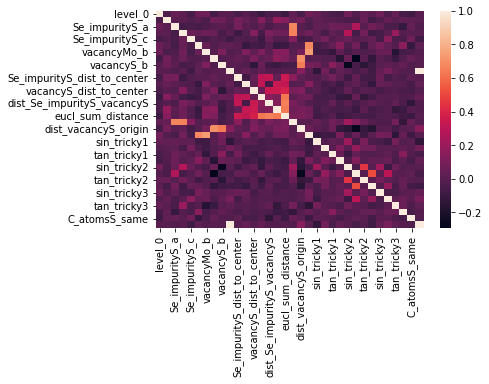

In [133]:
sns.heatmap(train_df.corr()) # никакой линейной связи нет

In [134]:
X_train = train_df.drop('targets', axis=1)
y_train = train_df.targets

X_test = test_df.drop('targets', axis=1)
y_test = test_df.targets

X_priv = priv_df.drop('targets', axis=1)
# no targets for priv
y_zero = priv_df.targets

y_train.head()

index
6141d87031cf3ef3d4a9ef74    0.3526
614376a431cf3ef3d4a9f762    0.4112
61421fb831cf3ef3d4a9f32c    0.4184
6141dbab31cf3ef3d4a9efce    0.3937
61428a5431cf3ef3d4a9f568    0.4005
Name: targets, dtype: float64

In [135]:
y_zero.unique()

array([0])

In [136]:
X_train.shape, X_test.shape, X_priv.shape

((501, 33), (201, 33), (713, 33))

In [137]:
y_train.index

Index(['6141d87031cf3ef3d4a9ef74', '614376a431cf3ef3d4a9f762',
       '61421fb831cf3ef3d4a9f32c', '6141dbab31cf3ef3d4a9efce',
       '61428a5431cf3ef3d4a9f568', '6142109e31cf3ef3d4a9f2b2',
       '61432bb631cf3ef3d4a9f6f8', '61428b3831cf3ef3d4a9f56c',
       '6141e3c431cf3ef3d4a9f07e', '614243be31cf3ef3d4a9f41a',
       ...
       '6142d94531cf3ef3d4a9f64e', '6141f40331cf3ef3d4a9f170',
       '6141d50831cf3ef3d4a9ef04', '6142547231cf3ef3d4a9f476',
       '6141cf6c31cf3ef3d4a9ed9a', '6141dec131cf3ef3d4a9f016',
       '61420d8e31cf3ef3d4a9f292', '6142f02631cf3ef3d4a9f688',
       '6142623531cf3ef3d4a9f4be', '6141cf1731cf3ef3d4a9ed44'],
      dtype='object', name='index', length=501)

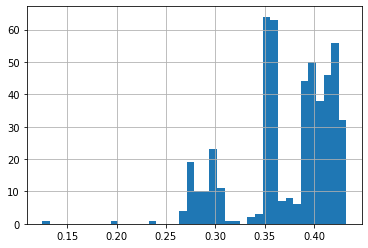

In [138]:
y_train.hist(bins=40)

In [139]:
X_train.shape, y_train.shape

((501, 33), (501,))

In [140]:
from sklearn.linear_model import LinearRegression
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
lr_raw.score(X_train, y_train), lr_raw.score(X_test, y_test)

(0.14746276530987923, 0.061800899085077576)

In [141]:
from itertools import combinations
column_list = X_train.columns
interactions = list(combinations(column_list, 2))
interactions

[('level_0', 'Se_impurityS_a'),
 ('level_0', 'Se_impurityS_b'),
 ('level_0', 'Se_impurityS_c'),
 ('level_0', 'vacancyMo_a'),
 ('level_0', 'vacancyMo_b'),
 ('level_0', 'vacancyS_a'),
 ('level_0', 'vacancyS_b'),
 ('level_0', 'vacancyS_c'),
 ('level_0', 'Se_impurityS_dist_to_center'),
 ('level_0', 'vacancyMo_dist_to_center'),
 ('level_0', 'vacancyS_dist_to_center'),
 ('level_0', 'dist_Se_impurityS_vacancyMo'),
 ('level_0', 'dist_Se_impurityS_vacancyS'),
 ('level_0', 'dist_vacancyMo_vacancyS'),
 ('level_0', 'eucl_sum_distance'),
 ('level_0', 'dist_Se_impurityS_origin'),
 ('level_0', 'dist_vacancyS_origin'),
 ('level_0', 'dist_vacancyMo_origin'),
 ('level_0', 'sin_tricky1'),
 ('level_0', 'cos_tricky1'),
 ('level_0', 'tan_tricky1'),
 ('level_0', 'ctg_tricky1'),
 ('level_0', 'sin_tricky2'),
 ('level_0', 'cos_tricky2'),
 ('level_0', 'tan_tricky2'),
 ('level_0', 'ctg_tricky2'),
 ('level_0', 'sin_tricky3'),
 ('level_0', 'cos_tricky3'),
 ('level_0', 'tan_tricky3'),
 ('level_0', 'ctg_tricky3'),
 (

In [142]:
from sklearn.linear_model import LinearRegression
interaction_dict = {}
for interaction in interactions:
   X_train_int = X_train.copy()
   X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
   lr3 = LinearRegression()
   lr3.fit(X_train_int, y_train)
   interaction_dict[lr3.score(X_train_int, y_train)] = interaction

In [143]:
top_15 = sorted(interaction_dict.keys(), reverse = True)[:15]
for interaction in top_15:
   print(interaction_dict[interaction])

('dist_vacancyMo_vacancyS', 'eucl_sum_distance')
('dist_Se_impurityS_vacancyS', 'dist_vacancyMo_vacancyS')
('dist_Se_impurityS_vacancyMo', 'dist_vacancyMo_vacancyS')
('vacancyMo_dist_to_center', 'eucl_sum_distance')
('vacancyS_dist_to_center', 'eucl_sum_distance')
('vacancyMo_dist_to_center', 'dist_Se_impurityS_vacancyS')
('dist_Se_impurityS_vacancyMo', 'eucl_sum_distance')
('vacancyS_dist_to_center', 'dist_vacancyMo_vacancyS')
('vacancyMo_dist_to_center', 'dist_vacancyMo_vacancyS')
('dist_Se_impurityS_vacancyS', 'eucl_sum_distance')
('dist_Se_impurityS_vacancyMo', 'sin_tricky3')
('eucl_sum_distance', 'tan_tricky1')
('dist_Se_impurityS_vacancyMo', 'dist_Se_impurityS_vacancyS')
('dist_vacancyMo_vacancyS', 'tan_tricky1')
('vacancyMo_dist_to_center', 'vacancyS_dist_to_center')


In [144]:
X_train_ext = X_train.copy()
X_test_ext = X_test.copy()
X_priv_ext = X_priv.copy()

for score in top_15:
  col1 = interaction_dict[score][0]
  col2 = interaction_dict[score][1]
  col_name = col1 + ' * ' + col2
  X_train_ext[col_name] = X_train_ext[col1] * X_train_ext[col2]
  X_test_ext[col_name] = X_test_ext[col1] * X_test_ext[col2]
  X_priv_ext[col_name] = X_priv_ext[col1] * X_priv_ext[col2]
  
X_train_ext.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,vacancyMo_a,vacancyMo_b,vacancyS_a,vacancyS_b,vacancyS_c,Se_impurityS_dist_to_center,...,vacancyMo_dist_to_center * dist_Se_impurityS_vacancyS,dist_Se_impurityS_vacancyMo * eucl_sum_distance,vacancyS_dist_to_center * dist_vacancyMo_vacancyS,vacancyMo_dist_to_center * dist_vacancyMo_vacancyS,dist_Se_impurityS_vacancyS * eucl_sum_distance,dist_Se_impurityS_vacancyMo * sin_tricky3,eucl_sum_distance * tan_tricky1,dist_Se_impurityS_vacancyMo * dist_Se_impurityS_vacancyS,dist_vacancyMo_vacancyS * tan_tricky1,vacancyMo_dist_to_center * vacancyS_dist_to_center
index,,,,,,,,,,,,,,,,,,,,,
6141d87031cf3ef3d4a9ef74,0,0.833,0.167,0.355,0.417,0.458,0.833,0.667,0.145,0.482497,...,0.050446,0.460966,0.184714,0.044394,0.482206,-0.297159,0.446728,0.281146,0.239772,0.036003
614376a431cf3ef3d4a9f762,8,0.083,0.667,0.355,0.292,0.333,0.958,0.417,0.355,0.461306,...,0.242742,0.492018,0.324198,0.181237,1.098076,0.345657,0.152190,0.371060,0.085694,0.127279
61421fb831cf3ef3d4a9f32c,16,0.208,0.792,0.355,0.292,0.083,0.958,0.667,0.355,0.426090,...,0.354318,0.993275,0.444812,0.415662,1.046552,0.716626,1.206932,0.548694,0.782151,0.232382
6141dbab31cf3ef3d4a9efce,19,0.958,0.792,0.355,0.167,0.583,0.458,0.792,0.145,0.553221,...,0.186114,0.870555,0.116907,0.128128,0.572355,0.210714,0.758013,0.447327,0.268145,0.107464
61428a5431cf3ef3d4a9f568,24,0.333,0.292,0.355,0.542,0.708,0.333,0.542,0.145,0.286667,...,0.069282,0.308044,0.057847,0.060861,0.210742,-0.426449,0.512659,0.155819,0.227801,0.042798


In [145]:
X_train_ext.shape, X_test_ext.shape, X_priv_ext.shape

((501, 48), (201, 48), (713, 48))

In [146]:
lr_bivar = LinearRegression()
lr_bivar.fit(X_train_ext, y_train)
lr_bivar.score(X_train_ext, y_train), lr_bivar.score(X_test_ext, y_test)

(0.35202145481704905, 0.1777169260598841)

In [147]:
(np.abs(lr_bivar.predict(X_test_ext) - y_test) < 0.02).mean() 

0.29850746268656714

In [98]:
from sklearn.preprocessing import PolynomialFeatures
poly_dict = {}
for feature in X_train_ext.columns:
   for p in range(2, 3): # no higher than 2
      X_train_poly = X_train_ext.copy()
      X_train_poly['sq'] = X_train_poly[feature] ** p
      lr = LinearRegression()
      lr.fit(X_train_poly, y_train)
      poly_dict[lr.score(X_train_poly, y_train)] = [feature, p]
poly_dict[max(poly_dict.keys())]

['eucl_sum_distance', 2]

In [99]:
#top_poly_15 = sorted(poly_dict.keys(), reverse = True)[:15]
all_poly = sorted(poly_dict.keys(), reverse = True)
# for poly in top_poly_15:
#    print(poly_dict[poly])

In [100]:
X_train_ext_poly = X_train_ext.copy()
X_test_ext_poly = X_test_ext.copy()
X_priv_ext_poly = X_priv_ext.copy()
for score in all_poly:
  var = poly_dict[score][0]
  exp = poly_dict[score][1]
  col_name = '(' + var + ')^' + str(exp)
  X_train_ext_poly[col_name] = X_train_ext_poly[var] ** exp
  X_test_ext_poly[col_name] = X_test_ext_poly[var] ** exp
  X_priv_ext_poly[col_name] = X_priv_ext_poly[var] ** exp
  
X_test_ext_poly.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,vacancyMo_a,vacancyMo_b,vacancyS_a,vacancyS_b,vacancyS_c,Se_impurityS_dist_to_center,...,(cos_tricky3)^2,(sin_tricky3)^2,(Se_impurityS_b)^2,(sin_tricky2)^2,(cos_tricky2)^2,(vacancyS_dist_to_center * eucl_sum_distance)^2,(vacancyMo_dist_to_center * dist_Se_impurityS_vacancyS)^2,(vacancyMo_dist_to_center * eucl_sum_distance)^2,(vacancyS_c)^2,(vacancyS_c_0_355)^2
index,,,,,,,,,,,,,,,,,,,,,
6141cf9d31cf3ef3d4a9edb8,3,0.333,0.667,0.355,0.917,0.708,0.208,0.042,0.145,0.258463,...,0.995095,0.004905,0.444889,0.961538,0.038462,0.539074,0.097795,0.382488,0.021025,0
6141f0f031cf3ef3d4a9f142,5,0.958,0.417,0.355,0.417,0.458,0.083,0.542,0.355,0.477156,...,0.994289,0.005711,0.173889,0.020000,0.980000,0.227052,0.006760,0.010524,0.126025,1
6142570431cf3ef3d4a9f48c,13,0.958,0.167,0.355,0.542,0.583,0.958,0.917,0.355,0.575915,...,0.500000,0.500000,0.027889,1.000000,0.000000,0.479642,0.004867,0.010516,0.126025,1
6143465f31cf3ef3d4a9f71e,22,0.708,0.042,0.355,0.917,0.708,0.833,0.917,0.355,0.513861,...,0.089650,0.910350,0.001764,0.980000,0.020000,0.396753,0.169651,0.291262,0.126025,1
6141f2e831cf3ef3d4a9f162,35,0.333,0.667,0.145,0.667,0.333,0.083,0.917,0.145,0.258463,...,0.500000,0.500000,0.444889,0.500000,0.500000,0.377559,0.006972,0.058694,0.021025,0


In [101]:
X_train_ext_poly.shape, X_test_ext_poly.shape, X_priv_ext_poly.shape

((501, 91), (201, 91), (713, 91))

In [102]:
lr_biv_poly = LinearRegression()
lr_biv_poly.fit(X_train_ext_poly, y_train)
lr_biv_poly.score(X_train_ext_poly, y_train), lr_biv_poly.score(X_test_ext_poly, y_test) 

(0.49099641368056124, 0.21517943636969228)

In [103]:
(np.abs(lr_biv_poly.predict(X_test_ext_poly) - y_test) < 0.02).mean()  

0.34328358208955223

### Леса

In [106]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [107]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train_ext_poly, y_train)
(np.abs(rf.predict(X_test_ext_poly) - y_test) < 0.02).mean() 

0.3681592039800995

In [108]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 100, max_depth = 1)
rf.fit(X_train_ext, y_train)
(np.abs(rf.predict(X_test_ext) - y_test) < 0.02).mean() 

0.3681592039800995

In [109]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train, y_train)
(np.abs(rf.predict(X_test) - y_test) < 0.02).mean() 

0.3681592039800995

In [111]:
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext, y_train)
(np.abs(gb.predict(X_test_ext) - y_test) < 0.02).mean() 

0.48756218905472637

In [112]:
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train, y_train)
(np.abs(gb.predict(X_test) - y_test) < 0.02).mean() 

0.5174129353233831

### AutoML 10 мин

In [113]:
df_automl = pd.concat([X_train_ext_poly, y_train], axis=1)
# for later stacking into public
# df_test_automl = pd.concat([X_test_ext_poly, y_test], axis=1) 
df_automl.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,vacancyMo_a,vacancyMo_b,vacancyS_a,vacancyS_b,vacancyS_c,Se_impurityS_dist_to_center,...,(sin_tricky3)^2,(Se_impurityS_b)^2,(sin_tricky2)^2,(cos_tricky2)^2,(vacancyS_dist_to_center * eucl_sum_distance)^2,(vacancyMo_dist_to_center * dist_Se_impurityS_vacancyS)^2,(vacancyMo_dist_to_center * eucl_sum_distance)^2,(vacancyS_c)^2,(vacancyS_c_0_355)^2,targets
index,,,,,,,,,,,,,,,,,,,,,
6141d87031cf3ef3d4a9ef74,0,0.833,0.167,0.355,0.417,0.458,0.833,0.667,0.145,0.482497,...,0.328556,0.027889,1.000000,0.000000,0.118438,0.002545,0.006841,0.021025,0,0.3526
614376a431cf3ef3d4a9f762,8,0.083,0.667,0.355,0.292,0.333,0.958,0.417,0.355,0.461306,...,0.718617,0.444889,0.075472,0.924528,0.331505,0.058924,0.103600,0.126025,1,0.4112
61421fb831cf3ef3d4a9f32c,16,0.208,0.792,0.355,0.292,0.083,0.958,0.667,0.355,0.426090,...,0.986158,0.627264,0.027027,0.972973,0.471126,0.125542,0.411402,0.126025,1,0.4184
6141dbab31cf3ef3d4a9efce,19,0.958,0.792,0.355,0.167,0.583,0.458,0.792,0.145,0.553221,...,0.065258,0.627264,0.000000,1.000000,0.109219,0.034639,0.131190,0.021025,0,0.3937
61428a5431cf3ef3d4a9f568,24,0.333,0.292,0.355,0.542,0.708,0.333,0.542,0.145,0.286667,...,0.798461,0.085264,1.000000,0.000000,0.016947,0.004800,0.018760,0.021025,0,0.4005


In [114]:
df_automl.columns

Index(['level_0', 'Se_impurityS_a', 'Se_impurityS_b', 'Se_impurityS_c',
       'vacancyMo_a', 'vacancyMo_b', 'vacancyS_a', 'vacancyS_b', 'vacancyS_c',
       'Se_impurityS_dist_to_center', 'vacancyMo_dist_to_center',
       'vacancyS_dist_to_center', 'dist_Se_impurityS_vacancyMo',
       'dist_Se_impurityS_vacancyS', 'dist_vacancyMo_vacancyS',
       'eucl_sum_distance', 'dist_Se_impurityS_origin', 'dist_vacancyS_origin',
       'dist_vacancyMo_origin', 'sin_tricky1', 'cos_tricky1', 'tan_tricky1',
       'ctg_tricky1', 'sin_tricky2', 'cos_tricky2', 'tan_tricky2',
       'ctg_tricky2', 'sin_tricky3', 'cos_tricky3', 'tan_tricky3',
       'ctg_tricky3', 'C_atomsS_same', 'vacancyS_c_0_355',
       'dist_vacancyMo_vacancyS * eucl_sum_distance',
       'dist_Se_impurityS_vacancyS * dist_vacancyMo_vacancyS',
       'dist_Se_impurityS_vacancyMo * dist_vacancyMo_vacancyS',
       'vacancyMo_dist_to_center * eucl_sum_distance',
       'vacancyS_dist_to_center * eucl_sum_distance',
       'vacanc

In [115]:
!pip install -U lightautoml

     |████████████████████████████████| 294 kB 5.2 MB/s 
     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 308 kB 47.0 MB/s 
     |████████████████████████████████| 212 kB 48.7 MB/s 
     |████████████████████████████████| 76.1 MB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 425 kB 40.8 MB/s 
     |████████████████████████████████| 2.8 MB 41.2 MB/s 
     |████████████████████████████████| 210 kB 48.8 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 113 kB 49.5 MB/s 
     |████████████████████████████████| 150 kB 49.9 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.7 MB/s 
     |████████████████████████████████| 23.3 MB 47.9 MB/s 
     |█████████████

In [116]:
# Import from lightautoml package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [117]:
# def task_loss(y_true, y_pred):
    #return (np.abs(y_true - y_pred) < 0.02).astype(int)#.mean()

In [118]:
# lgbm feval
# https://neptune.ai/blog/lightgbm-parameters-guide

def task_metric(y_true, y_pred):
    return (np.abs(y_true - y_pred) < 0.02).mean()#.   #.astype(int)#.mean() #.astype(int)#.mean() !# no minus
  #return ('task_metric', (np.abs(y_true - y_pred) < 0.02).mean(), False)

In [119]:
task = Task('reg', loss = 'mae', metric=task_metric, greater_is_better=True) #https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html, https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936

In [120]:
N_THREADS = 3 # threads (potoki, parallelization) count for lgbm and linear models
N_FOLDS = 5 # folds count for AutoML
RANDOM_STATE = 666 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check (cross-validation!!!!)
TIMEOUT = 600 # Time in seconds for automl run 
TARGET_NAME = 'targets' # Target column name

In [121]:
roles = {'target': TARGET_NAME,
         'drop': ['level_0']#'drop': ['level_0', 'index']
        }

In [ ]:
# CHANGED TabularAutoML to TabularUtilizedAutoML for timeout utilization
automl = TabularUtilizedAutoML(task = task, 
                      timeout = TIMEOUT, 
                      cpu_limit = N_THREADS,
                      # PUT THE SECOND LIST OF THE SAME MODELS IN STACKING OR DO NOT DO THAT!!!
                      # 2 lists of same algorithms to make model stacking!!!!!
                      general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned'], ['linear_l2', 'lgb', 'lgb_tuned']]},
                      reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                              )

oof_pred = automl.fit_predict(df_automl, roles = roles)
oof_pred.head(2)

Выходные данные были обрезаны до нескольких последних строк (5000).
DEBUG:lightautoml.ml_algo.boost_lgbm:[478]	valid's l1: 0.0253948	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[479]	valid's l1: 0.0253972	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[480]	valid's l1: 0.0254005	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[481]	valid's l1: 0.0253967	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[482]	valid's l1: 0.0253972	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[483]	valid's l1: 0.0253966	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[484]	valid's l1: 0.025388	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[485]	valid's l1: 0.0253837	valid's Opt metric: 0.514851
DEBUG:lightautoml.ml_algo.boost_lgbm:[486]	valid's l1: 0.0253811	valid's Opt metric: 0.524752
DEBUG:lightautoml.ml_algo.boost_lgbm:[487]	valid's l1: 0.025377	valid's Opt metric: 0.5

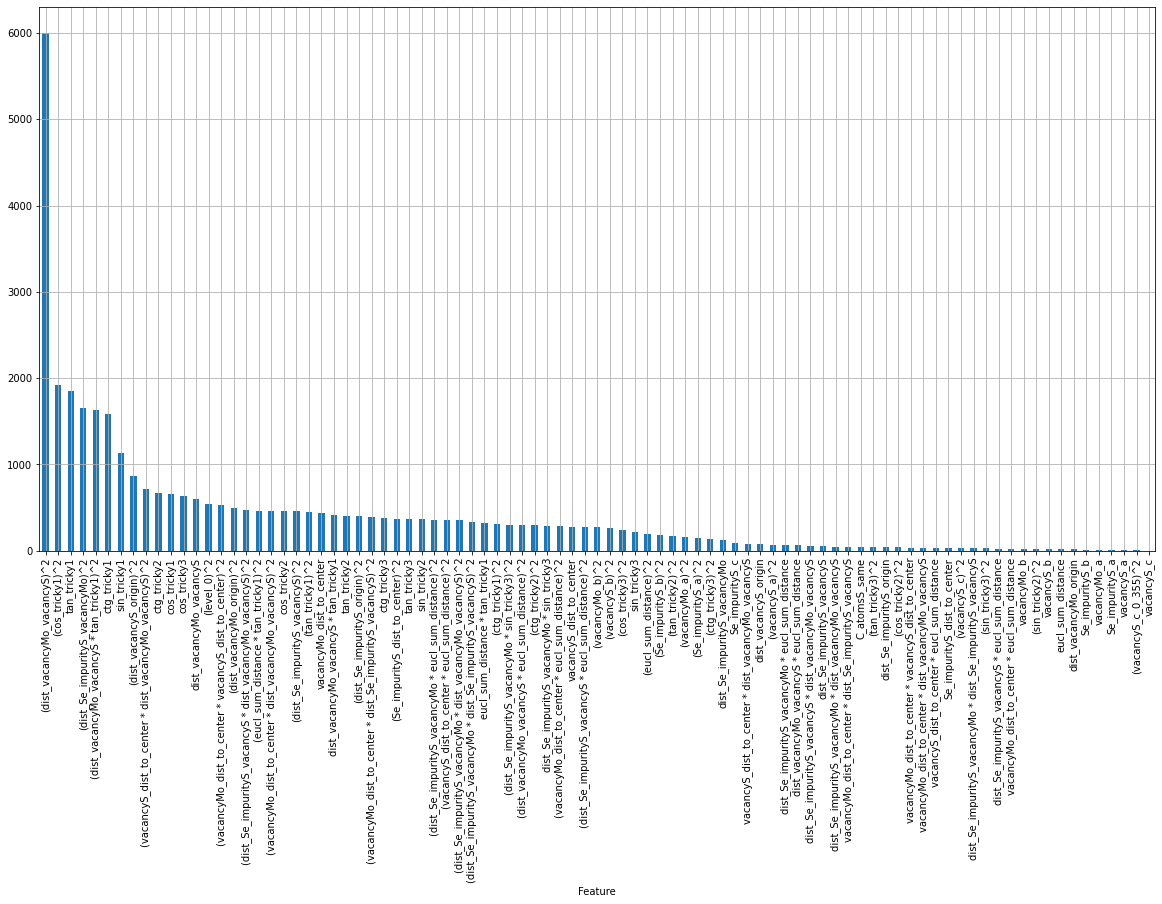

In [124]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [125]:
df_test_automl = pd.concat([X_test_ext_poly, y_test], axis=1)
df_priv_automl = pd.concat([X_priv_ext_poly, y_zero], axis=1)
df_test_automl.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,vacancyMo_a,vacancyMo_b,vacancyS_a,vacancyS_b,vacancyS_c,Se_impurityS_dist_to_center,...,(sin_tricky3)^2,(Se_impurityS_b)^2,(sin_tricky2)^2,(cos_tricky2)^2,(vacancyS_dist_to_center * eucl_sum_distance)^2,(vacancyMo_dist_to_center * dist_Se_impurityS_vacancyS)^2,(vacancyMo_dist_to_center * eucl_sum_distance)^2,(vacancyS_c)^2,(vacancyS_c_0_355)^2,targets
index,,,,,,,,,,,,,,,,,,,,,
6141cf9d31cf3ef3d4a9edb8,3,0.333,0.667,0.355,0.917,0.708,0.208,0.042,0.145,0.258463,...,0.004905,0.444889,0.961538,0.038462,0.539074,0.097795,0.382488,0.021025,0,0.4158
6141f0f031cf3ef3d4a9f142,5,0.958,0.417,0.355,0.417,0.458,0.083,0.542,0.355,0.477156,...,0.005711,0.173889,0.020000,0.980000,0.227052,0.006760,0.010524,0.126025,1,0.4243
6142570431cf3ef3d4a9f48c,13,0.958,0.167,0.355,0.542,0.583,0.958,0.917,0.355,0.575915,...,0.500000,0.027889,1.000000,0.000000,0.479642,0.004867,0.010516,0.126025,1,0.4105
6143465f31cf3ef3d4a9f71e,22,0.708,0.042,0.355,0.917,0.708,0.833,0.917,0.355,0.513861,...,0.910350,0.001764,0.980000,0.020000,0.396753,0.169651,0.291262,0.126025,1,0.3916
6141f2e831cf3ef3d4a9f162,35,0.333,0.667,0.145,0.667,0.333,0.083,0.917,0.145,0.258463,...,0.500000,0.444889,0.500000,0.500000,0.377559,0.006972,0.058694,0.021025,0,0.3575


In [126]:
# predicting the test data
test_pred_automl = automl.predict(df_test_automl) 

In [127]:
np.abs((test_pred_automl.data - np.array(y_train)) < 0.02).mean()

0.6354653876326948

In [128]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.66075 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.60094 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.39906 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


	+ 0.10483 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.50000 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.50000 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


	+ 0.23442 * 1 averaged models with config = "conf_5_sel_type_1_tuning_full.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 





In [129]:
fast_fi # already sorted

,Feature,Importance
0,(dist_vacancyMo_vacancyS)^2,6000.415153
1,(cos_tricky1)^2,1919.914594
2,tan_tricky1,1848.544897
3,(dist_Se_impurityS_vacancyMo)^2,1648.686325
4,(dist_vacancyMo_vacancyS * tan_tricky1)^2,1630.743138
...,...,...
84,vacancyMo_a,10.089175
85,Se_impurityS_a,9.795885
86,vacancyS_a,6.419410
87,(vacancyS_c_0_355)^2,2.658895


In [130]:
fast_fi.Feature.to_list()

['(dist_vacancyMo_vacancyS)^2',
 '(cos_tricky1)^2',
 'tan_tricky1',
 '(dist_Se_impurityS_vacancyMo)^2',
 '(dist_vacancyMo_vacancyS * tan_tricky1)^2',
 'ctg_tricky1',
 'sin_tricky1',
 '(dist_vacancyS_origin)^2',
 '(vacancyS_dist_to_center * dist_vacancyMo_vacancyS)^2',
 'ctg_tricky2',
 'cos_tricky1',
 'cos_tricky3',
 'dist_vacancyMo_vacancyS',
 '(level_0)^2',
 '(vacancyMo_dist_to_center * vacancyS_dist_to_center)^2',
 '(dist_vacancyMo_origin)^2',
 '(dist_Se_impurityS_vacancyS * dist_vacancyMo_vacancyS)^2',
 '(eucl_sum_distance * tan_tricky1)^2',
 '(vacancyMo_dist_to_center * dist_vacancyMo_vacancyS)^2',
 'cos_tricky2',
 '(dist_Se_impurityS_vacancyS)^2',
 '(tan_tricky1)^2',
 'vacancyMo_dist_to_center',
 'dist_vacancyMo_vacancyS * tan_tricky1',
 'tan_tricky2',
 '(dist_Se_impurityS_origin)^2',
 '(vacancyMo_dist_to_center * dist_Se_impurityS_vacancyS)^2',
 'ctg_tricky3',
 '(Se_impurityS_dist_to_center)^2',
 'tan_tricky3',
 'sin_tricky2',
 '(dist_Se_impurityS_vacancyMo * eucl_sum_distance)^2

#### LightGBM on AutoML-important features

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train) 
(np.abs(lgb_reg.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

0.5343915343915344

In [ ]:
gb = GradientBoostingRegressor(loss='squared_error', criterion='absolute_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train)
(np.abs(gb.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


0.4497354497354497

#### AutoML inside an AutoML - matreshka!

In [ ]:
feat20 = fast_fi.Feature.to_list()[:20]
feat20.append('targets')
feat20

['(dist_vacancyMo_vacancyS)^2',
 '(dist_Se_impurityS_vacancyMo)^2',
 'tan_tricky1',
 'sin_tricky1',
 '(cos_tricky1)^2',
 '(vacancyMo_dist_to_center * dist_vacancyMo_vacancyS)^2',
 '(level_0)^2',
 '(cos_tricky3)^2',
 '(dist_Se_impurityS_origin)^2',
 'sin_tricky3',
 '(vacancyS_dist_to_center * dist_Se_impurityS_vacancyMo)^2',
 'dist_vacancyMo_vacancyS',
 '(dist_Se_impurityS_vacancyS * dist_vacancyMo_vacancyS)^2',
 'cos_tricky1',
 '(dist_Se_impurityS_vacancyMo * eucl_sum_distance)^2',
 '(Se_impurityS_dist_to_center)^2',
 '(dist_vacancyMo_vacancyS * eucl_sum_distance)^2',
 'ctg_tricky3',
 '(vacancyMo_dist_to_center * vacancyS_dist_to_center)^2',
 '(dist_vacancyS_origin)^2',
 'targets']

In [ ]:
oof_pred2 = automl.fit_predict(df_automl[feat20], roles = roles)

In [ ]:
test_pred_automl2 = automl.predict(df_test_automl[feat20]) 
np.abs((test_pred_automl2.data - np.array(y_train)) < 0.02).mean()

0.6154996544860093

#### Creating Submission from Matreshka AutoML

In [ ]:
df_pub = pd.concat([df_automl[feat20], df_test_automl], axis=0)

In [ ]:
oof_pred3 = automl.fit_predict(df_pub[feat20], roles = roles) # save these weights somhow is great
priv_pred = automl.predict(df_priv_automl[feat20]) # нужна пусткая колонка targets!!!

In [ ]:
priv_pred.shape

(713, 1)

In [ ]:
priv_pred.data.shape

(713, 1)

In [ ]:
np.array(priv_pred.data).squeeze().shape

(713,)

In [ ]:
# gr10000
file_name = './submission_' + groupname + '.csv'
#priv_pred = priv_pred.rename('predictions')
gr10000 = pd.DataFrame(data={'predictions': priv_pred.data.reshape(-1)}, index=df_priv_automl.index)
gr10000.to_csv(file_name, index_label='id')

## Group 1 000

In [ ]:
groupname = 'gr1000'





train_df = train_df1000.copy()
train_df.index = train_df['index']
train_df.drop(['index'], axis=1, inplace=True) 




test_df = valid_df1000.copy()
test_df.index = test_df['index']
test_df.drop(['index'], axis=1, inplace=True)


priv_df = private_df1000.copy()
priv_df.index = priv_df['index']
priv_df.drop(['index'], axis=1, inplace=True)


train_df.head()

--2022-03-13 16:20:54--  https://docs.google.com/uc?export=download&confirm=&id=1uRzmpaYrrpMCrH6T1dI7BYq6hFyk9gbp
Resolving docs.google.com (docs.google.com)... 142.250.141.113, 142.250.141.100, 142.250.141.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1gac9fbnjghj446co0hm5dr70e50liv9/1647188400000/16870991581384366815/*/1uRzmpaYrrpMCrH6T1dI7BYq6hFyk9gbp?e=download [following]
--2022-03-13 16:20:54--  https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1gac9fbnjghj446co0hm5dr70e50liv9/1647188400000/16870991581384366815/*/1uRzmpaYrrpMCrH6T1dI7BYq6hFyk9gbp?e=download
Resolving doc-10-7k-docs.googleusercontent.com (doc-10-7k-docs.googleusercontent.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to doc-10-7k-docs.googleusercontent.com (doc-1

,level_0,targets,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,vacancy_Mo_b,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,Se1_impurityS_c_0_355
index,,,,,,,,,,,,,,,,,,,,,
6142112eee0a3fd43fb47e6d,4,0.3589,0.708,0.667,0.145,0.708,0.292,0.355,0.292,0.958,...,0.573198,-0.819417,-0.699528,-1.429528,-0.848141,0.529770,-1.600931,-0.624632,0,1
6141cf3fee0a3fd43fb47a15,6,0.3601,0.333,0.917,0.355,0.958,0.792,0.145,0.792,0.208,...,0.839443,-0.543448,-1.544691,-0.647383,-0.961896,-0.273416,3.518201,0.284250,0,0
614248d6ee0a3fd43fb47f1d,20,0.3595,0.458,0.292,0.145,0.708,0.542,0.145,0.917,0.958,...,0.823392,0.567473,1.450955,0.689181,0.893566,0.448931,1.990386,0.502398,1,0
61422bd6ee0a3fd43fb47ed9,36,0.3587,0.833,0.417,0.145,0.833,0.917,0.145,0.292,0.708,...,0.473711,-0.880680,-0.537899,-1.859067,-0.360365,-0.932811,0.386326,2.588589,1,0
6141d338ee0a3fd43fb47b3d,40,0.3595,0.583,0.542,0.355,0.458,0.792,0.145,0.917,0.458,...,0.243902,-0.969800,-0.251500,-3.976027,-0.588381,0.808584,-0.727660,-1.374275,0,0


In [ ]:
# train_df.drop(['vacancyMo_c'],axis=1, inplace=True)
# test_df.drop(['vacancyMo_c'],axis=1, inplace=True)
# priv_df.drop(['vacancyMo_c'],axis=1, inplace=True)
train_df.head()

,level_0,targets,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,vacancy_Mo_b,...,sin_tricky2,cos_tricky2,tan_tricky2,ctg_tricky2,sin_tricky3,cos_tricky3,tan_tricky3,ctg_tricky3,C_atomsS_same,Se1_impurityS_c_0_355
index,,,,,,,,,,,,,,,,,,,,,
6142112eee0a3fd43fb47e6d,4,0.3589,0.708,0.667,0.145,0.708,0.292,0.355,0.292,0.958,...,0.573198,-0.819417,-0.699528,-1.429528,-0.848141,0.529770,-1.600931,-0.624632,0,1
6141cf3fee0a3fd43fb47a15,6,0.3601,0.333,0.917,0.355,0.958,0.792,0.145,0.792,0.208,...,0.839443,-0.543448,-1.544691,-0.647383,-0.961896,-0.273416,3.518201,0.284250,0,0
614248d6ee0a3fd43fb47f1d,20,0.3595,0.458,0.292,0.145,0.708,0.542,0.145,0.917,0.958,...,0.823392,0.567473,1.450955,0.689181,0.893566,0.448931,1.990386,0.502398,1,0
61422bd6ee0a3fd43fb47ed9,36,0.3587,0.833,0.417,0.145,0.833,0.917,0.145,0.292,0.708,...,0.473711,-0.880680,-0.537899,-1.859067,-0.360365,-0.932811,0.386326,2.588589,1,0
6141d338ee0a3fd43fb47b3d,40,0.3595,0.583,0.542,0.355,0.458,0.792,0.145,0.917,0.458,...,0.243902,-0.969800,-0.251500,-3.976027,-0.588381,0.808584,-0.727660,-1.374275,0,0


In [ ]:
train_df.shape, test_df.shape,  priv_df.shape # targets filled with 0s

((284, 35), (93, 35), (366, 35))

In [ ]:
priv_df.columns

Index(['level_0', 'targets', 'Se_impurityS_a', 'Se_impurityS_b',
       'Se_impurityS_c', 'Se1_impurityS_a', 'Se1_impurityS_b',
       'Se1_impurityS_c', 'vacancy_Mo_a', 'vacancy_Mo_b', 'vacancy_Mo_c',
       'Se_impurityS_dist_to_center', 'Se1_impurityS_dist_to_center',
       'vacancy_Mo_dist_to_center', 'dist_Se_impurityS_Se1_impurityS',
       'dist_Se_impurityS_vacancy_Mo', 'dist_Se1_impurityS_vacancy_Mo',
       'eucl_sum_distance', 'dist_Se_impurityS_origin',
       'dist_vacancy_Mo_origin', 'dist_Se1_impurityS_origin', 'sin_tricky1',
       'cos_tricky1', 'tan_tricky1', 'ctg_tricky1', 'sin_tricky2',
       'cos_tricky2', 'tan_tricky2', 'ctg_tricky2', 'sin_tricky3',
       'cos_tricky3', 'tan_tricky3', 'ctg_tricky3', 'C_atomsS_same',
       'Se1_impurityS_c_0_355'],
      dtype='object')

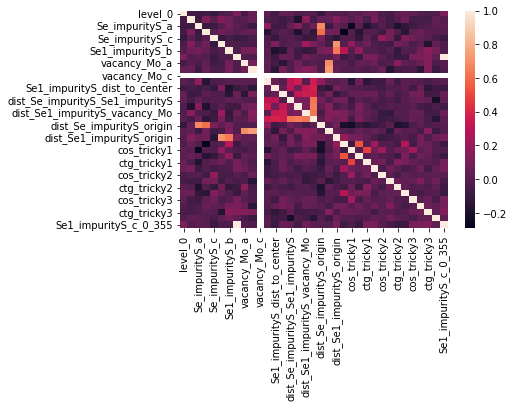

In [ ]:
sns.heatmap(train_df.corr()) # никакой линейной связи нет

In [ ]:
X_train = train_df.drop('targets', axis=1)
y_train = train_df.targets

X_test = test_df.drop('targets', axis=1)
y_test = test_df.targets

X_priv = priv_df.drop('targets', axis=1)
# no targets for priv
y_zero = priv_df.targets

y_train.head()

index
6142112eee0a3fd43fb47e6d    0.3589
6141cf3fee0a3fd43fb47a15    0.3601
614248d6ee0a3fd43fb47f1d    0.3595
61422bd6ee0a3fd43fb47ed9    0.3587
6141d338ee0a3fd43fb47b3d    0.3595
Name: targets, dtype: float64

In [ ]:
y_zero.unique()

array([0])

In [ ]:
X_train.shape, X_test.shape, X_priv.shape

((284, 34), (93, 34), (366, 34))

In [ ]:
y_train.index

Index(['6142112eee0a3fd43fb47e6d', '6141cf3fee0a3fd43fb47a15',
       '614248d6ee0a3fd43fb47f1d', '61422bd6ee0a3fd43fb47ed9',
       '6141d338ee0a3fd43fb47b3d', '6141d172ee0a3fd43fb47ae3',
       '61421fd4ee0a3fd43fb47eb3', '6141d3a3ee0a3fd43fb47b4d',
       '6141f70eee0a3fd43fb47dc3', '6141d6bfee0a3fd43fb47bbb',
       ...
       '6142640dee0a3fd43fb47f49', '6141cf15ee0a3fd43fb479db',
       '6141d254ee0a3fd43fb47b15', '6141d12aee0a3fd43fb47ad3',
       '61420bdbee0a3fd43fb47e53', '6141cf21ee0a3fd43fb479f3',
       '6141e0b8ee0a3fd43fb47c9f', '614236feee0a3fd43fb47ef9',
       '6141cf1cee0a3fd43fb479eb', '6141d38dee0a3fd43fb47b49'],
      dtype='object', name='index', length=284)

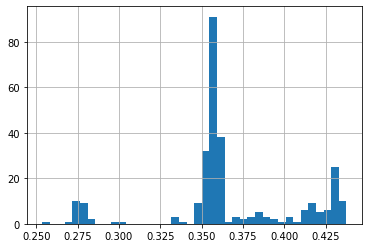

In [ ]:
y_train.hist(bins=40)

In [ ]:
X_train.shape, y_train.shape

((284, 34), (284,))

In [ ]:
from sklearn.linear_model import LinearRegression
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
lr_raw.score(X_train, y_train), lr_raw.score(X_test, y_test)

(0.18636788552581673, -0.3090814114373037)

In [ ]:
from itertools import combinations
column_list = X_train.columns
interactions = list(combinations(column_list, 2))
interactions

[('level_0', 'Se_impurityS_a'),
 ('level_0', 'Se_impurityS_b'),
 ('level_0', 'Se_impurityS_c'),
 ('level_0', 'Se1_impurityS_a'),
 ('level_0', 'Se1_impurityS_b'),
 ('level_0', 'Se1_impurityS_c'),
 ('level_0', 'vacancy_Mo_a'),
 ('level_0', 'vacancy_Mo_b'),
 ('level_0', 'vacancy_Mo_c'),
 ('level_0', 'Se_impurityS_dist_to_center'),
 ('level_0', 'Se1_impurityS_dist_to_center'),
 ('level_0', 'vacancy_Mo_dist_to_center'),
 ('level_0', 'dist_Se_impurityS_Se1_impurityS'),
 ('level_0', 'dist_Se_impurityS_vacancy_Mo'),
 ('level_0', 'dist_Se1_impurityS_vacancy_Mo'),
 ('level_0', 'eucl_sum_distance'),
 ('level_0', 'dist_Se_impurityS_origin'),
 ('level_0', 'dist_vacancy_Mo_origin'),
 ('level_0', 'dist_Se1_impurityS_origin'),
 ('level_0', 'sin_tricky1'),
 ('level_0', 'cos_tricky1'),
 ('level_0', 'tan_tricky1'),
 ('level_0', 'ctg_tricky1'),
 ('level_0', 'sin_tricky2'),
 ('level_0', 'cos_tricky2'),
 ('level_0', 'tan_tricky2'),
 ('level_0', 'ctg_tricky2'),
 ('level_0', 'sin_tricky3'),
 ('level_0', 'cos_

In [ ]:
from sklearn.linear_model import LinearRegression
interaction_dict = {}
for interaction in interactions:
   X_train_int = X_train.copy()
   X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
   lr3 = LinearRegression()
   lr3.fit(X_train_int, y_train)
   interaction_dict[lr3.score(X_train_int, y_train)] = interaction

In [ ]:
top_15 = sorted(interaction_dict.keys(), reverse = True)[:15]
for interaction in top_15:
   print(interaction_dict[interaction])

('dist_Se1_impurityS_vacancy_Mo', 'ctg_tricky2')
('Se_impurityS_b', 'vacancy_Mo_b')
('eucl_sum_distance', 'ctg_tricky2')
('Se_impurityS_a', 'sin_tricky1')
('Se1_impurityS_b', 'dist_Se_impurityS_vacancy_Mo')
('Se_impurityS_b', 'dist_vacancy_Mo_origin')
('sin_tricky3', 'Se1_impurityS_c_0_355')
('Se1_impurityS_c', 'sin_tricky3')
('dist_vacancy_Mo_origin', 'sin_tricky2')
('Se1_impurityS_a', 'dist_Se_impurityS_origin')
('dist_Se_impurityS_origin', 'sin_tricky1')
('level_0', 'ctg_tricky2')
('dist_Se1_impurityS_vacancy_Mo', 'tan_tricky1')
('Se_impurityS_b', 'Se1_impurityS_a')
('Se1_impurityS_b', 'vacancy_Mo_dist_to_center')


In [ ]:
X_train_ext = X_train.copy()
X_test_ext = X_test.copy()
X_priv_ext = X_priv.copy()

for score in top_15:
  col1 = interaction_dict[score][0]
  col2 = interaction_dict[score][1]
  col_name = col1 + ' * ' + col2
  X_train_ext[col_name] = X_train_ext[col1] * X_train_ext[col2]
  X_test_ext[col_name] = X_test_ext[col1] * X_test_ext[col2]
  X_priv_ext[col_name] = X_priv_ext[col1] * X_priv_ext[col2]
  
X_train_ext.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,vacancy_Mo_b,vacancy_Mo_c,...,Se_impurityS_b * dist_vacancy_Mo_origin,sin_tricky3 * Se1_impurityS_c_0_355,Se1_impurityS_c * sin_tricky3,dist_vacancy_Mo_origin * sin_tricky2,Se1_impurityS_a * dist_Se_impurityS_origin,dist_Se_impurityS_origin * sin_tricky1,level_0 * ctg_tricky2,dist_Se1_impurityS_vacancy_Mo * tan_tricky1,Se_impurityS_b * Se1_impurityS_a,Se1_impurityS_b * vacancy_Mo_dist_to_center
index,,,,,,,,,,,,,,,,,,,,,
6142112eee0a3fd43fb47e6d,4,0.708,0.667,0.145,0.708,0.292,0.355,0.292,0.958,0.25,...,0.688507,-0.848141,-0.301090,0.591680,0.696284,-0.983452,-5.718113,-79223.544480,0.472236,0.146882
6141cf3fee0a3fd43fb47a15,6,0.333,0.917,0.355,0.958,0.792,0.145,0.792,0.208,0.25,...,0.785108,-0.000000,-0.139475,0.718706,0.994570,0.203602,-3.884298,-0.123231,0.878486,0.327057
614248d6ee0a3fd43fb47f1d,20,0.458,0.292,0.145,0.708,0.542,0.145,0.917,0.958,0.25,...,0.394054,0.000000,0.129567,1.111168,0.398028,0.397525,13.783616,0.477237,0.206736,0.335713
61422bd6ee0a3fd43fb47ed9,36,0.833,0.417,0.145,0.833,0.917,0.145,0.292,0.708,0.25,...,0.335945,-0.000000,-0.052253,0.381633,0.785322,0.942763,-66.926422,58939.545299,0.347361,0.269741
6141d338ee0a3fd43fb47b3d,40,0.583,0.542,0.355,0.458,0.792,0.145,0.917,0.458,0.25,...,0.571843,-0.000000,-0.085315,0.257331,0.399191,-0.779578,-159.041098,-1.154551,0.248236,0.331935


In [ ]:
X_train_ext.shape, X_test_ext.shape, X_priv_ext.shape

((284, 49), (93, 49), (366, 49))

In [ ]:
lr_bivar = LinearRegression()
lr_bivar.fit(X_train_ext, y_train)
lr_bivar.score(X_train_ext, y_train), lr_bivar.score(X_test_ext, y_test) # тупо переобучение

(0.4047190360388331, -0.36327035213656345)

In [ ]:
(np.abs(lr_bivar.predict(X_test_ext) - y_test) < 0.02).mean() 

0.40860215053763443

In [ ]:
#(np.abs(lr_bivar.predict(X_test_ext_poly) - y_test) < 0.02).mean() #получше 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_dict = {}
for feature in X_train_ext.columns:
   for p in range(2, 3): # no higher than 2
      X_train_poly = X_train_ext.copy()
      X_train_poly['sq'] = X_train_poly[feature] ** p
      lr = LinearRegression()
      lr.fit(X_train_poly, y_train)
      poly_dict[lr.score(X_train_poly, y_train)] = [feature, p]
poly_dict[max(poly_dict.keys())]

['dist_Se1_impurityS_vacancy_Mo', 2]

In [ ]:
#top_poly_15 = sorted(poly_dict.keys(), reverse = True)[:15]
all_poly = sorted(poly_dict.keys(), reverse = True)
# for poly in top_poly_15:
#    print(poly_dict[poly])

In [ ]:
X_train_ext_poly = X_train_ext.copy()
X_test_ext_poly = X_test_ext.copy()
X_priv_ext_poly = X_priv_ext.copy()
for score in all_poly:
  var = poly_dict[score][0]
  exp = poly_dict[score][1]
  col_name = '(' + var + ')^' + str(exp)
  X_train_ext_poly[col_name] = X_train_ext_poly[var] ** exp
  X_test_ext_poly[col_name] = X_test_ext_poly[var] ** exp
  X_priv_ext_poly[col_name] = X_priv_ext_poly[var] ** exp
  
X_test_ext_poly.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,vacancy_Mo_b,vacancy_Mo_c,...,(level_0 * ctg_tricky2)^2,(tan_tricky1)^2,(Se_impurityS_b)^2,(dist_Se1_impurityS_vacancy_Mo * ctg_tricky2)^2,(Se1_impurityS_b * dist_Se_impurityS_vacancy_Mo)^2,(Se1_impurityS_c * sin_tricky3)^2,(dist_Se_impurityS_Se1_impurityS)^2,(Se1_impurityS_c_0_355)^2,(Se1_impurityS_c)^2,(C_atomsS_same)^2
index,,,,,,,,,,,,,,,,,,,,,
6142725fee0a3fd43fb47f59,10,0.708,0.917,0.355,0.583,0.542,0.355,0.667,0.833,0.25,...,23.823166,9.000569,0.840889,0.024481,0.005805,0.116332,0.156250,1,0.126025,1
6141d14eee0a3fd43fb47adb,17,0.458,0.792,0.355,0.208,0.292,0.355,0.417,0.458,0.25,...,4.354756,4.000179,0.627264,0.001240,0.010595,0.048749,0.312500,1,0.126025,1
6141cfacee0a3fd43fb47a59,25,0.458,0.917,0.355,0.208,0.167,0.355,0.167,0.458,0.25,...,251.206192,9.000569,0.840889,0.039143,0.008545,0.123572,0.625000,1,0.126025,1
6141cf36ee0a3fd43fb47a0d,27,0.833,0.667,0.145,0.333,0.417,0.355,0.542,0.208,0.25,...,293.020780,0.250006,0.444889,0.039547,0.053277,0.063012,0.356600,1,0.126025,0
614277dbee0a3fd43fb47f61,31,0.708,0.792,0.355,0.208,0.417,0.355,0.667,0.708,0.25,...,228.940625,0.562514,0.627264,0.072991,0.003436,0.036132,0.390625,1,0.126025,1


In [ ]:
X_train_ext_poly.shape, X_test_ext_poly.shape, X_priv_ext_poly.shape

((284, 92), (93, 92), (366, 92))

In [ ]:
lr_biv_poly = LinearRegression()
lr_biv_poly.fit(X_train_ext_poly, y_train)
lr_biv_poly.score(X_train_ext_poly, y_train), lr_biv_poly.score(X_test_ext_poly, y_test) 

(0.538136177275218, -0.49231121994293736)

In [ ]:
(np.abs(lr_biv_poly.predict(X_test_ext_poly) - y_test) < 0.02).mean()  

0.34408602150537637

In [ ]:
# from sklearn.linear_model import HuberRegressor
# huber = HuberRegressor(max_iter=1000).fit(X_train_ext_poly, y_train)
# huber.score(X_train_ext_poly, y_train), huber.score(X_test_ext_poly, y_test)

In [ ]:
# # huber.predict(X_test_ext_poly)
# (np.abs(huber.predict(X_test_ext_poly) - y_test) < 0.02).mean()

#### Леса

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train_ext_poly, y_train)
(np.abs(rf.predict(X_test_ext_poly) - y_test) < 0.02).mean() 

0.6344086021505376

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 100, max_depth = 1)
rf.fit(X_train_ext, y_train)
(np.abs(rf.predict(X_test_ext) - y_test) < 0.02).mean() 

0.6344086021505376

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train, y_train)
(np.abs(rf.predict(X_test) - y_test) < 0.02).mean() 

0.6344086021505376

In [ ]:
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext, y_train) # new feautes make GB worse
(np.abs(gb.predict(X_test_ext) - y_test) < 0.02).mean() 

0.5161290322580645

In [ ]:
# best we could get
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train, y_train) # new feautes make GB worse
(np.abs(gb.predict(X_test) - y_test) < 0.02).mean() 

0.5268817204301075

#### AutoML 10 мин

In [ ]:
df_automl = pd.concat([X_train_ext_poly, y_train], axis=1)

df_automl.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,vacancy_Mo_b,vacancy_Mo_c,...,(tan_tricky1)^2,(Se_impurityS_b)^2,(dist_Se1_impurityS_vacancy_Mo * ctg_tricky2)^2,(Se1_impurityS_b * dist_Se_impurityS_vacancy_Mo)^2,(Se1_impurityS_c * sin_tricky3)^2,(dist_Se_impurityS_Se1_impurityS)^2,(Se1_impurityS_c_0_355)^2,(Se1_impurityS_c)^2,(C_atomsS_same)^2,targets
index,,,,,,,,,,,,,,,,,,,,,
6142112eee0a3fd43fb47e6d,4,0.708,0.667,0.145,0.708,0.292,0.355,0.292,0.958,0.25,...,1.000000e+10,0.444889,1.282608,0.022916,0.090655,0.184725,1,0.126025,0,0.3589
6141cf3fee0a3fd43fb47a15,6,0.333,0.917,0.355,0.958,0.792,0.145,0.792,0.208,0.25,...,4.000082e-02,0.840889,0.159108,0.454382,0.019453,0.450350,0,0.021025,0,0.3601
614248d6ee0a3fd43fb47f1d,20,0.458,0.292,0.145,0.708,0.542,0.145,0.917,0.958,0.25,...,9.999717e-01,0.085264,0.108180,0.195430,0.016788,0.125000,0,0.021025,1,0.3595
61422bd6ee0a3fd43fb47ed9,36,0.833,0.417,0.145,0.833,0.917,0.145,0.292,0.708,0.25,...,1.000000e+10,0.173889,1.200615,0.326590,0.002730,0.250000,0,0.021025,1,0.3587
6141d338ee0a3fd43fb47b3d,40,0.583,0.542,0.355,0.458,0.792,0.145,0.917,0.458,0.25,...,3.999821e+00,0.293764,5.268470,0.081317,0.007279,0.122225,0,0.021025,0,0.3595


In [ ]:
df_automl.columns

Index(['level_0', 'Se_impurityS_a', 'Se_impurityS_b', 'Se_impurityS_c',
       'Se1_impurityS_a', 'Se1_impurityS_b', 'Se1_impurityS_c', 'vacancy_Mo_a',
       'vacancy_Mo_b', 'vacancy_Mo_c', 'Se_impurityS_dist_to_center',
       'Se1_impurityS_dist_to_center', 'vacancy_Mo_dist_to_center',
       'dist_Se_impurityS_Se1_impurityS', 'dist_Se_impurityS_vacancy_Mo',
       'dist_Se1_impurityS_vacancy_Mo', 'eucl_sum_distance',
       'dist_Se_impurityS_origin', 'dist_vacancy_Mo_origin',
       'dist_Se1_impurityS_origin', 'sin_tricky1', 'cos_tricky1',
       'tan_tricky1', 'ctg_tricky1', 'sin_tricky2', 'cos_tricky2',
       'tan_tricky2', 'ctg_tricky2', 'sin_tricky3', 'cos_tricky3',
       'tan_tricky3', 'ctg_tricky3', 'C_atomsS_same', 'Se1_impurityS_c_0_355',
       'dist_Se1_impurityS_vacancy_Mo * ctg_tricky2',
       'Se_impurityS_b * vacancy_Mo_b', 'eucl_sum_distance * ctg_tricky2',
       'Se_impurityS_a * sin_tricky1',
       'Se1_impurityS_b * dist_Se_impurityS_vacancy_Mo',
       'Se

In [ ]:
!pip install -U lightautoml

     |████████████████████████████████| 294 kB 5.3 MB/s 
     |████████████████████████████████| 804.1 MB 2.5 kB/s 
     |████████████████████████████████| 308 kB 53.4 MB/s 
     |████████████████████████████████| 212 kB 57.9 MB/s 
     |████████████████████████████████| 76.1 MB 52 kB/s 
     |████████████████████████████████| 1.2 MB 40.5 MB/s 
     |████████████████████████████████| 425 kB 61.6 MB/s 
     |████████████████████████████████| 2.8 MB 31.9 MB/s 
     |████████████████████████████████| 81 kB 7.9 MB/s 
     |████████████████████████████████| 210 kB 55.4 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 113 kB 49.3 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 150 kB 55.6 MB/s 
     |████████████████████████████████| 21.0 MB 8.6 MB/s 
     |████████████████████████████████| 23.2 MB 66.8 MB/s 
     |████████████████████████████████| 23.3 MB 1.4 MB/s 
     |██████████████

In [ ]:
# Import from lightautoml package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [ ]:
# def task_loss(y_true, y_pred):
    #return (np.abs(y_true - y_pred) < 0.02).astype(int)#.mean()

In [ ]:
# lgbm feval
# https://neptune.ai/blog/lightgbm-parameters-guide

def task_metric(y_true, y_pred):
    return (np.abs(y_true - y_pred) < 0.02).mean()#.   #.astype(int)#.mean() #.astype(int)#.mean() !# no minus
  #return ('task_metric', (np.abs(y_true - y_pred) < 0.02).mean(), False)

In [ ]:
task = Task('reg', loss = 'mae', metric=task_metric, greater_is_better=True) #https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html, https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936

In [ ]:
N_THREADS = 3 # threads (potoki, parallelization) count for lgbm and linear models
N_FOLDS = 5 # folds count for AutoML
RANDOM_STATE = 666 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check (cross-validation!!!!)
TIMEOUT = 300 # Time in seconds for automl run 
TARGET_NAME = 'targets' # Target column name

In [ ]:
roles = {'target': TARGET_NAME,
         'drop': ['level_0']#'drop': ['level_0', 'index']
        }

In [ ]:
# CHANGED TabularAutoML to TabularUtilizedAutoML for timeout utilization
automl = TabularUtilizedAutoML(task = task, 
                      timeout = TIMEOUT, 
                      cpu_limit = N_THREADS,
                      # PUT THE SECOND LIST OF THE SAME MODELS IN STACKING OR DO NOT DO THAT!!!
                      # 2 lists of same algorithms to make model stacking!!!!!
                      general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned'], ['linear_l2', 'lgb', 'lgb_tuned']]},
                      reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                              )

oof_pred = automl.fit_predict(df_automl, roles = roles)

In [ ]:
# automl.get_feature_scores('fast') # yields nothing because more time required!!!

In [ ]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

AttributeError: ignored

In [ ]:
df_test_automl = pd.concat([X_test_ext_poly, y_test], axis=1)
df_priv_automl = pd.concat([X_priv_ext_poly, y_zero], axis=1)
df_test_automl.head()

,level_0,Se_impurityS_a,Se_impurityS_b,Se_impurityS_c,Se1_impurityS_a,Se1_impurityS_b,Se1_impurityS_c,vacancy_Mo_a,vacancy_Mo_b,vacancy_Mo_c,...,(tan_tricky1)^2,(Se_impurityS_b)^2,(dist_Se1_impurityS_vacancy_Mo * ctg_tricky2)^2,(Se1_impurityS_b * dist_Se_impurityS_vacancy_Mo)^2,(Se1_impurityS_c * sin_tricky3)^2,(dist_Se_impurityS_Se1_impurityS)^2,(Se1_impurityS_c_0_355)^2,(Se1_impurityS_c)^2,(C_atomsS_same)^2,targets
index,,,,,,,,,,,,,,,,,,,,,
6142725fee0a3fd43fb47f59,10,0.708,0.917,0.355,0.583,0.542,0.355,0.667,0.833,0.25,...,9.000569,0.840889,0.024481,0.005805,0.116332,0.156250,1,0.126025,1,0.2666
6141d14eee0a3fd43fb47adb,17,0.458,0.792,0.355,0.208,0.292,0.355,0.417,0.458,0.25,...,4.000179,0.627264,0.001240,0.010595,0.048749,0.312500,1,0.126025,1,0.4360
6141cfacee0a3fd43fb47a59,25,0.458,0.917,0.355,0.208,0.167,0.355,0.167,0.458,0.25,...,9.000569,0.840889,0.039143,0.008545,0.123572,0.625000,1,0.126025,1,0.3584
6141cf36ee0a3fd43fb47a0d,27,0.833,0.667,0.145,0.333,0.417,0.355,0.542,0.208,0.25,...,0.250006,0.444889,0.039547,0.053277,0.063012,0.356600,1,0.126025,0,0.3576
614277dbee0a3fd43fb47f61,31,0.708,0.792,0.355,0.208,0.417,0.355,0.667,0.708,0.25,...,0.562514,0.627264,0.072991,0.003436,0.036132,0.390625,1,0.126025,1,0.2742


In [ ]:
# predicting the test data
test_pred_automl = automl.predict(df_test_automl) 

In [ ]:
np.abs((test_pred_automl.data - np.array(y_train)) < 0.02).mean()

0.8512418597607149

In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	1.00000 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM

		Final prediction for new objects (level 1) = 
			 0.84549 * (5 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) +
			 0.15451 * (5 averaged models Lvl_1_Pipe_1_Mod_1_Tuned_LightGBM) 





In [ ]:
automl.get_config()

AttributeError: ignored

In [ ]:
automl.configs_list

['/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_0_sel_type_0.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_1_sel_type_1.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_2_select_mode_1_no_typ.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_3_sel_type_1_no_inter_lgbm.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_4_sel_type_0_no_int.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_5_sel_type_1_tuning_full.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_6_sel_type_1_tuning_full_no_int_lgbm.yml']

In [ ]:
for path in automl.configs_list:
    !ln -s $path | tr -d "'"

In [ ]:
path1 = '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_0_sel_type_0.yml'

'/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_0_sel_type_0.yml'

In [ ]:
!ln -s /usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_0_sel_type_0.yml conf_0_sel_type_0.yml

In [ ]:
automl.automl_factory

lightautoml.automl.presets.tabular_presets.TabularAutoML

In [ ]:
automl.plot_pdp()

TypeError: ignored

In [ ]:
automl.random_state_keys

{'reader_params': {'random_state': 42}}

In [ ]:
automl.configs_list

['/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_0_sel_type_0.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_1_sel_type_1.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_2_select_mode_1_no_typ.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_3_sel_type_1_no_inter_lgbm.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_4_sel_type_0_no_int.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_5_sel_type_1_tuning_full.yml',
 '/usr/local/lib/python3.7/dist-packages/lightautoml/automl/presets/tabular_configs/conf_6_sel_type_1_tuning_full_no_int_lgbm.yml']

In [ ]:
fast_fi # already sorted

In [ ]:
fast_fi.Feature.to_list()

AttributeError: ignored

##### LightGBM on AutoML-important features

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_reg = lgb.LGBMRegressor()#, objective=task_metric)
lgb_reg.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train) # new feautes make GB worse
(np.abs(lgb_reg.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

In [ ]:
# best we could get
gb = GradientBoostingRegressor(loss='squared_error', criterion='absolute_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train) # new feautes make GB worse
(np.abs(gb.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

##### AutoML inside an AutoML - matreshka!

In [ ]:
feat20 = fast_fi.Feature.to_list()[:20]
feat20.append('targets')
feat20

In [ ]:
oof_pred2 = automl.fit_predict(df_automl[feat20], roles = roles)

In [ ]:
test_pred_automl2 = automl.predict(df_test_automl[feat20]) 
np.abs((test_pred_automl2.data - np.array(y_train)) < 0.02).mean()

##### Creating Submission from Matreshka AutoML

In [ ]:
df_pub = pd.concat([df_automl[feat20], df_test_automl], axis=0)

In [ ]:
oof_pred3 = automl.fit_predict(df_pub[feat20], roles = roles) 
priv_pred = automl.predict(df_priv_automl[feat20]) 

In [ ]:
priv_pred.shape

In [ ]:
df_priv_automl.index

In [ ]:
# gr1000
file_name = './submission_' + groupname + '.csv'
#priv_pred = priv_pred.rename('predictions')
gr1000 = pd.DataFrame(data={'predictions': priv_pred}, index=df_priv_automl.index)
gr1000.to_csv(file_name, index_label='id')

## Group 0

In [ ]:
groupname = 'gr0'

train_df = train_df0.copy()
train_df.index = train_df['index']
train_df.drop(['index'], axis=1, inplace=True) 


test_df = valid_df0.copy()
test_df.index = test_df['index']
test_df.drop(['index'], axis=1, inplace=True)


priv_df = private_df0.copy()
priv_df.index = priv_df['index']
priv_df.drop(['index'], axis=1, inplace=True)


train_df.head()

In [ ]:
train_df.head()

In [ ]:
train_df.shape, test_df.shape,  priv_df.shape 

In [ ]:
priv_df.columns

In [ ]:
sns.heatmap(train_df.corr()) 

In [ ]:
X_train = train_df.drop('targets', axis=1)
y_train = train_df.targets

X_test = test_df.drop('targets', axis=1)
y_test = test_df.targets

X_priv = priv_df.drop('targets', axis=1)
# no targets for priv
y_zero = priv_df.targets

y_train.head()

In [ ]:
y_zero.unique()

In [ ]:
X_train.shape, X_test.shape, X_priv.shape

In [ ]:
y_train.index

In [ ]:
y_train.hist(bins=40)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
from sklearn.linear_model import LinearRegression
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
lr_raw.score(X_train, y_train), lr_raw.score(X_test, y_test)

In [ ]:
from itertools import combinations
column_list = X_train.columns
interactions = list(combinations(column_list, 2))
interactions

In [ ]:
from sklearn.linear_model import LinearRegression
interaction_dict = {}
for interaction in interactions:
   X_train_int = X_train.copy()
   X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
   lr3 = LinearRegression()
   lr3.fit(X_train_int, y_train)
   interaction_dict[lr3.score(X_train_int, y_train)] = interaction

In [ ]:
top_15 = sorted(interaction_dict.keys(), reverse = True)[:15]
for interaction in top_15:
   print(interaction_dict[interaction])

In [ ]:
X_train_ext = X_train.copy()
X_test_ext = X_test.copy()
X_priv_ext = X_priv.copy()

for score in top_15:
  col1 = interaction_dict[score][0]
  col2 = interaction_dict[score][1]
  col_name = col1 + ' * ' + col2
  X_train_ext[col_name] = X_train_ext[col1] * X_train_ext[col2]
  X_test_ext[col_name] = X_test_ext[col1] * X_test_ext[col2]
  X_priv_ext[col_name] = X_priv_ext[col1] * X_priv_ext[col2]
  
X_train_ext.head()

In [ ]:
X_train_ext.shape, X_test_ext.shape, X_priv_ext.shape

In [ ]:
lr_bivar = LinearRegression()
lr_bivar.fit(X_train_ext, y_train)
lr_bivar.score(X_train_ext, y_train), lr_bivar.score(X_test_ext, y_test) 

In [ ]:
(np.abs(lr_bivar.predict(X_test_ext) - y_test) < 0.02).mean() 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_dict = {}
for feature in X_train_ext.columns:
   for p in range(2, 3): # no higher than 2
      X_train_poly = X_train_ext.copy()
      X_train_poly['sq'] = X_train_poly[feature] ** p
      lr = LinearRegression()
      lr.fit(X_train_poly, y_train)
      poly_dict[lr.score(X_train_poly, y_train)] = [feature, p]
poly_dict[max(poly_dict.keys())]

In [ ]:
#top_poly_15 = sorted(poly_dict.keys(), reverse = True)[:15]
all_poly = sorted(poly_dict.keys(), reverse = True)
# for poly in top_poly_15:
#    print(poly_dict[poly])

In [ ]:
X_train_ext_poly = X_train_ext.copy()
X_test_ext_poly = X_test_ext.copy()
X_priv_ext_poly = X_priv_ext.copy()
for score in all_poly:
  var = poly_dict[score][0]
  exp = poly_dict[score][1]
  col_name = '(' + var + ')^' + str(exp)
  X_train_ext_poly[col_name] = X_train_ext_poly[var] ** exp
  X_test_ext_poly[col_name] = X_test_ext_poly[var] ** exp
  X_priv_ext_poly[col_name] = X_priv_ext_poly[var] ** exp
  
X_test_ext_poly.head()

In [ ]:
X_train_ext_poly.shape, X_test_ext_poly.shape, X_priv_ext_poly.shape

In [ ]:
lr_biv_poly = LinearRegression()
lr_biv_poly.fit(X_train_ext_poly, y_train)
lr_biv_poly.score(X_train_ext_poly, y_train), lr_biv_poly.score(X_test_ext_poly, y_test) 

In [ ]:
(np.abs(lr_biv_poly.predict(X_test_ext_poly) - y_test) < 0.02).mean()  

### Леса

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train_ext_poly, y_train)
(np.abs(rf.predict(X_test_ext_poly) - y_test) < 0.02).mean() 

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 100, max_depth = 1)
rf.fit(X_train_ext, y_train)
(np.abs(rf.predict(X_test_ext) - y_test) < 0.02).mean() 

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train, y_train)
(np.abs(rf.predict(X_test) - y_test) < 0.02).mean() 

In [ ]:
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext, y_train) 
(np.abs(gb.predict(X_test_ext) - y_test) < 0.02).mean() 

In [ ]:
# best we could get
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train, y_train) 
(np.abs(gb.predict(X_test) - y_test) < 0.02).mean() 

### AutoML 10 мин

In [ ]:
df_automl = pd.concat([X_train_ext_poly, y_train], axis=1)
# for later stacking into public
# df_test_automl = pd.concat([X_test_ext_poly, y_test], axis=1) 
df_automl.head()

In [ ]:
df_automl.columns

In [ ]:
!pip install -U lightautoml

In [ ]:
# Import from lightautoml package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [ ]:
# lgbm feval
# https://neptune.ai/blog/lightgbm-parameters-guide

def task_metric(y_true, y_pred):
    return (np.abs(y_true - y_pred) < 0.02).mean()#.   #.astype(int)#.mean() #.astype(int)#.mean() !# no minus
  #return ('task_metric', (np.abs(y_true - y_pred) < 0.02).mean(), False)

In [ ]:
task = Task('reg', loss = 'mae', metric=task_metric, greater_is_better=True) #https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html, https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936

In [ ]:
N_THREADS = 3 # threads (potoki, parallelization) count for lgbm and linear models
N_FOLDS = 5 # folds count for AutoML
RANDOM_STATE = 666 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check (cross-validation!!!!)
TIMEOUT = 600 # Time in seconds for automl run 
TARGET_NAME = 'targets' # Target column name

In [ ]:
roles = {'target': TARGET_NAME,
         'drop': ['level_0']#'drop': ['level_0', 'index']
        }

In [ ]:
# CHANGED TabularAutoML to TabularUtilizedAutoML for timeout utilization
automl = TabularUtilizedAutoML(task = task, 
                      timeout = TIMEOUT, 
                      cpu_limit = N_THREADS,
                      # PUT THE SECOND LIST OF THE SAME MODELS IN STACKING OR DO NOT DO THAT!!!
                      # 2 lists of same algorithms to make model stacking!!!!!
                      general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned'], ['linear_l2', 'lgb', 'lgb_tuned']]},
                      reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                              )

oof_pred = automl.fit_predict(df_automl, roles = roles)

In [ ]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [ ]:
df_test_automl = pd.concat([X_test_ext_poly, y_test], axis=1)
df_priv_automl = pd.concat([X_priv_ext_poly, y_zero], axis=1)
df_test_automl.head()

In [ ]:
# predicting the test data
test_pred_automl = automl.predict(df_test_automl) 

In [ ]:
np.abs((test_pred_automl.data - np.array(y_train)) < 0.02).mean()

In [ ]:
print(automl.create_model_str_desc())

In [ ]:
fast_fi # already sorted

In [ ]:
fast_fi.Feature.to_list()

#### LightGBM on AutoML-important features

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_reg = lgb.LGBMRegressor()#, objective=task_metric)
lgb_reg.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train) # new feautes make GB worse
(np.abs(lgb_reg.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

In [ ]:
# best we could get
gb = GradientBoostingRegressor(loss='squared_error', criterion='absolute_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train) # new feautes make GB worse
(np.abs(gb.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

#### AutoML inside an AutoML - matreshka!

In [ ]:
feat20 = fast_fi.Feature.to_list()[:20]
feat20.append('targets')
feat20

In [ ]:
oof_pred2 = automl.fit_predict(df_automl[feat20], roles = roles)

In [ ]:
test_pred_automl2 = automl.predict(df_test_automl[feat20]) 
np.abs((test_pred_automl2.data - np.array(y_train)) < 0.02).mean()

#### Creating Submission from Matreshka AutoML

In [ ]:
df_pub = pd.concat([df_automl[feat20], df_test_automl], axis=0)

In [ ]:
oof_pred3 = automl.fit_predict(df_pub[feat20], roles = roles) 
priv_pred = automl.predict(df_priv_automl[feat20]) 

In [ ]:
priv_pred.shape

In [ ]:
df_priv_automl.index

In [ ]:
# gr0
file_name = './submission_' + groupname + '.csv'
#priv_pred = priv_pred.rename('predictions')
gr0 = pd.DataFrame(data={'predictions': priv_pred}, index=df_priv_automl.index)
gr0.to_csv(file_name, index_label='id')

## Group 100 000

In [ ]:
groupname = 'gr100000'


train_df = train_df100000.copy()
train_df.index = train_df['index']
train_df.drop(['index'], axis=1, inplace=True) 


test_df = valid_df1000
test_df.index = test_df['index']
test_df.drop(['index'], axis=1, inplace=True)


priv_df = private_df1000.copy()
priv_df.index = priv_df['index']
priv_df.drop(['index'], axis=1, inplace=True)



train_df.head()

In [ ]:
#train_df1000.to_csv('train_group_1000_final_general.csv', index = False)
#valid_df1000.to_csv('test_group_1000_final_general.csv', index = False)
#private_df1000.to_csv('private_group_1000_final_general.csv', index = False)

In [ ]:
# train_df.drop(['vacancyMo_c'],axis=1, inplace=True)
# test_df.drop(['vacancyMo_c'],axis=1, inplace=True)
# priv_df.drop(['vacancyMo_c'],axis=1, inplace=True)
train_df.head()

In [ ]:
train_df.shape, test_df.shape,  priv_df.shape # targets filled with 0s

In [ ]:
priv_df.columns

In [ ]:
sns.heatmap(train_df.corr()) # никакой линейной связи нет

In [ ]:
X_train = train_df.drop('targets', axis=1)
y_train = train_df.targets

X_test = test_df.drop('targets', axis=1)
y_test = test_df.targets

X_priv = priv_df.drop('targets', axis=1)
# no targets for priv
y_zero = priv_df.targets

y_train.head()

In [ ]:
y_zero.unique()

In [ ]:
X_train.shape, X_test.shape, X_priv.shape

In [ ]:
y_train.index

In [ ]:
y_train.hist(bins=40)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
from sklearn.linear_model import LinearRegression
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
lr_raw.score(X_train, y_train), lr_raw.score(X_test, y_test)

In [ ]:
from itertools import combinations
column_list = X_train.columns
interactions = list(combinations(column_list, 2))
interactions

In [ ]:
from sklearn.linear_model import LinearRegression
interaction_dict = {}
for interaction in interactions:
   X_train_int = X_train.copy()
   X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
   lr3 = LinearRegression()
   lr3.fit(X_train_int, y_train)
   interaction_dict[lr3.score(X_train_int, y_train)] = interaction

In [ ]:
top_15 = sorted(interaction_dict.keys(), reverse = True)[:15]
for interaction in top_15:
   print(interaction_dict[interaction])

In [ ]:
X_train_ext = X_train.copy()
X_test_ext = X_test.copy()
X_priv_ext = X_priv.copy()

for score in top_15:
  col1 = interaction_dict[score][0]
  col2 = interaction_dict[score][1]
  col_name = col1 + ' * ' + col2
  X_train_ext[col_name] = X_train_ext[col1] * X_train_ext[col2]
  X_test_ext[col_name] = X_test_ext[col1] * X_test_ext[col2]
  X_priv_ext[col_name] = X_priv_ext[col1] * X_priv_ext[col2]
  
X_train_ext.head()

In [ ]:
X_train_ext.shape, X_test_ext.shape, X_priv_ext.shape

In [ ]:
lr_bivar = LinearRegression()
lr_bivar.fit(X_train_ext, y_train)
lr_bivar.score(X_train_ext, y_train), lr_bivar.score(X_test_ext, y_test) # тупо переобучение

In [ ]:
(np.abs(lr_bivar.predict(X_test_ext) - y_test) < 0.02).mean() 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_dict = {}
for feature in X_train_ext.columns:
   for p in range(2, 3): # no higher than 2
      X_train_poly = X_train_ext.copy()
      X_train_poly['sq'] = X_train_poly[feature] ** p
      lr = LinearRegression()
      lr.fit(X_train_poly, y_train)
      poly_dict[lr.score(X_train_poly, y_train)] = [feature, p]
poly_dict[max(poly_dict.keys())]

In [ ]:
#top_poly_15 = sorted(poly_dict.keys(), reverse = True)[:15]
all_poly = sorted(poly_dict.keys(), reverse = True)
# for poly in top_poly_15:
#    print(poly_dict[poly])

In [ ]:
X_train_ext_poly = X_train_ext.copy()
X_test_ext_poly = X_test_ext.copy()
X_priv_ext_poly = X_priv_ext.copy()
for score in all_poly:
  var = poly_dict[score][0]
  exp = poly_dict[score][1]
  col_name = '(' + var + ')^' + str(exp)
  X_train_ext_poly[col_name] = X_train_ext_poly[var] ** exp
  X_test_ext_poly[col_name] = X_test_ext_poly[var] ** exp
  X_priv_ext_poly[col_name] = X_priv_ext_poly[var] ** exp
  
X_test_ext_poly.head()

In [ ]:
X_train_ext_poly.shape, X_test_ext_poly.shape, X_priv_ext_poly.shape

In [ ]:
lr_biv_poly = LinearRegression()
lr_biv_poly.fit(X_train_ext_poly, y_train)
lr_biv_poly.score(X_train_ext_poly, y_train), lr_biv_poly.score(X_test_ext_poly, y_test) 

In [ ]:
(np.abs(lr_biv_poly.predict(X_test_ext_poly) - y_test) < 0.02).mean()  

In [ ]:
# from sklearn.linear_model import HuberRegressor
# huber = HuberRegressor(max_iter=1000).fit(X_train_ext_poly, y_train)
# huber.score(X_train_ext_poly, y_train), huber.score(X_test_ext_poly, y_test)

In [ ]:
# # huber.predict(X_test_ext_poly)
# (np.abs(huber.predict(X_test_ext_poly) - y_test) < 0.02).mean()

### Леса

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train_ext_poly, y_train)
(np.abs(rf.predict(X_test_ext_poly) - y_test) < 0.02).mean() 

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 100, max_depth = 1)
rf.fit(X_train_ext, y_train)
(np.abs(rf.predict(X_test_ext) - y_test) < 0.02).mean() 

In [ ]:
rf = RandomForestRegressor(criterion='absolute_error', n_estimators = 1000, max_depth = 1)
rf.fit(X_train, y_train)
(np.abs(rf.predict(X_test) - y_test) < 0.02).mean() 

In [ ]:
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext, y_train) 
(np.abs(gb.predict(X_test_ext) - y_test) < 0.02).mean() 

In [ ]:
# best we could get
gb = GradientBoostingRegressor(loss='huber', criterion='squared_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train, y_train) 
(np.abs(gb.predict(X_test) - y_test) < 0.02).mean() 

### AutoML 10 мин

In [ ]:
df_automl = pd.concat([X_train_ext_poly, y_train], axis=1)
# for later stacking into public
# df_test_automl = pd.concat([X_test_ext_poly, y_test], axis=1) 
df_automl.head()

In [ ]:
df_automl.columns

In [ ]:
!pip install -U lightautoml

In [ ]:
# Import from lightautoml package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [ ]:
# lgbm feval
# https://neptune.ai/blog/lightgbm-parameters-guide

def task_metric(y_true, y_pred):
    return (np.abs(y_true - y_pred) < 0.02).mean()#.   #.astype(int)#.mean() #.astype(int)#.mean() !# no minus
  #return ('task_metric', (np.abs(y_true - y_pred) < 0.02).mean(), False)

In [ ]:
task = Task('reg', loss = 'mae', metric=task_metric, greater_is_better=True) #https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html, https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936

In [ ]:
N_THREADS = 3 # threads (potoki, parallelization) count for lgbm and linear models
N_FOLDS = 5 # folds count for AutoML
RANDOM_STATE = 666 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check (cross-validation!!!!)
TIMEOUT = 600 # Time in seconds for automl run 
TARGET_NAME = 'targets' # Target column name

In [ ]:
roles = {'target': TARGET_NAME,
         'drop': ['level_0']#'drop': ['level_0', 'index']
        }

In [ ]:
# CHANGED TabularAutoML to TabularUtilizedAutoML for timeout utilization
automl = TabularUtilizedAutoML(task = task, 
                      timeout = TIMEOUT, 
                      cpu_limit = N_THREADS,
                      # PUT THE SECOND LIST OF THE SAME MODELS IN STACKING OR DO NOT DO THAT!!!
                      # 2 lists of same algorithms to make model stacking!!!!!
                      general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned'], ['linear_l2', 'lgb', 'lgb_tuned']]},
                      reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                              )

oof_pred = automl.fit_predict(df_automl, roles = roles)

In [ ]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
if  str(type(fast_fi)) != "<class 'NoneType'>":
  fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [ ]:
df_test_automl = pd.concat([X_test_ext_poly, y_test], axis=1)
df_priv_automl = pd.concat([X_priv_ext_poly, y_zero], axis=1)
df_test_automl.head()

In [ ]:
# predicting the test data
test_pred_automl = automl.predict(df_test_automl) 

In [ ]:
np.abs((test_pred_automl.data - np.array(y_train)) < 0.02).mean()

In [ ]:
print(automl.create_model_str_desc())

In [ ]:
fast_fi 

#### LightGBM on AutoML-important features

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
fast_fi

In [ ]:
fast_fi = fast_fi.Feature.to_list()[:20] if str(type(fast_fi)) != "<class 'NoneType'>" else df_automl.columns

In [ ]:
lgb_reg = lgb.LGBMRegressor()#, objective=task_metric)
lgb_reg.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train) # new feautes make GB worse
(np.abs(lgb_reg.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

In [ ]:
# best we could get
gb = GradientBoostingRegressor(loss='squared_error', criterion='absolute_error', n_estimators = 1000, max_depth = 1, learning_rate = 1) # huber is slighly better # criterion='absolute_error' is worse # criterion='squared_error'is very clause to defualt friedman mse
gb.fit(X_train_ext_poly[fast_fi.Feature.to_list()[:20]], y_train) # new feautes make GB worse
(np.abs(gb.predict(X_test_ext_poly[fast_fi.Feature.to_list()[:20]]) - y_test) < 0.02).mean() 

#### AutoML inside an AutoML - matreshka!

In [ ]:
feat20 = fast_fi.Feature.to_list()[:20] if str(type(fast_fi)) != "<class 'NoneType'>" else df_automl.columns
feat20.append('targets')
feat20

In [ ]:
oof_pred2 = automl.fit_predict(df_automl[feat20], roles = roles)

In [ ]:
test_pred_automl2 = automl.predict(df_test_automl[feat20]) 
np.abs((test_pred_automl2.data - np.array(y_train)) < 0.02).mean()

#### Creating Submission from Matreshka AutoML

In [ ]:
df_pub = pd.concat([df_automl[feat20], df_test_automl], axis=0)

In [ ]:
oof_pred3 = automl.fit_predict(df_pub[feat20], roles = roles) 
priv_pred = automl.predict(df_priv_automl[feat20]) 

In [ ]:
priv_pred.shape

In [ ]:
df_priv_automl.index

In [ ]:
# gr100000
file_name = './submission_' + groupname + '.csv'
#priv_pred = priv_pred.rename('predictions')
gr100000 = pd.DataFrame(data={'predictions': priv_pred}, index=df_priv_automl.index)
gr100000.to_csv(file_name, index_label='id')

# Replacing modes with model-based predictions

In [ ]:
submission = modes.copy()
for upd in [gr0, gr1000, gr10000, gr100000]:
    submission.update(upd)
submission.to_csv('./submission.csv', index_label='id')